In [1]:
from os import chdir, listdir
import os
import re
from datetime import datetime, timedelta
import numpy as np
from math import ceil, floor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import mean_squared_error

Populating the interactive namespace from numpy and matplotlib


/home/vladislav/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['ceil', 'floor', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# os.chdir()

In [3]:
# os.listdir()

In [4]:
import pandas as pd
from scipy.stats import binned_statistic_2d
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 25, 10
sns.set()

In [5]:
def prepare_data(df):
    df = df.copy()
    df.drop(df.loc[df['tpep_pickup_datetime'] == df['tpep_dropoff_datetime']].index.values, inplace=True)
    df.drop(df[df['passenger_count']==0].index, inplace=True)
    df.drop(df[df['trip_distance']==0].index, inplace=True)
    df.drop(df[(df['pickup_longitude']<-74.25559) | (df['pickup_longitude']>-73.70001) | (df['pickup_latitude']<40.49612) | (df['pickup_latitude']>40.91553)].index,inplace=True)
#     time = pd.DatetimeIndex(df['tpep_pickup_datetime'])
#     df['Hours'] = time.day*24 + time.hour
    df['Hours'] = df['tpep_pickup_datetime'].apply(lambda x: datetime.datetime.strptime(x[:-6], '%Y-%m-%d %H'))
    return df

In [6]:
def prepare_time_data(df):
    df= df.copy()
    y = np.linspace(-74.25559,-73.70001,51)
    x = np.linspace(40.49612,40.91553,51)
    time_array = np.array([])
    for i in tqdm(sorted(list(set(df['Hours'])))):
        new_x = df[df['Hours']==i]['pickup_latitude'].values
        new_y = df[df['Hours']==i]['pickup_longitude'].values
        score = binned_statistic_2d(new_y,new_x,new_y,'count',bins=[y,x]).statistic
        if time_array.size==0:
            time_array=score
        else:
            time_array = np.vstack((time_array,score))
    return time_array

In [7]:
class TimeSplit:
    def __init__(self, time_series, start, period, step):
        self.period = period
        self.start = start
        self.step = step
        self.time = time_series
        
    def __iter__(self):
        return self
        
    def __next__(self):
        self.time_train = self.time[: self.start]
        self.time_predict = self.time[self.start : self.start + self.period]
        self.start += 1
        if len(self.time_predict) == 6:
            return self.time_train, self.time_predict
        else:
            raise StopIteration

In [8]:
def add_time(df, df1):
    time_array = df.copy()
    time_region = pd.DataFrame()
    houres = sorted(list(set(df1['Hours'])))
    for i in range(int(time_array.shape[0]/50)):
        time_region[houres[i]] = time_array[i*50:(i+1)*50].reshape(-1)
    return time_region

In [9]:
def diff_model(df, diff, feature):
    df = df.copy()
    for i in diff:
        df[feature] = df[feature] - df[feature].shift(i)
    return df

In [10]:
def by_season(data, files, model, fit=True):
    cars = [x.loc[region] for x in data for region in range(2500)]
    seasons = [pd.concat(tuple([cars[j*int(len(cars)/len(files))+i] for j in range(len(files))])) for i in range(2500)]
    seasons = pd.concat(tuple(seasons[i] for i in range(len(seasons))),axis=1)
    seasons.columns = [x for x in range(1,2501)]
    if fit:
        prep_seasons = pd.DataFrame(data=model.fit_transform(seasons[regions.values]),
                                    columns=regions.values, index=seasons.index)
        return prep_seasons, model
    else:
        prep_seasons = pd.DataFrame(data=model.transform(seasons[regions.values]),
                                    columns=regions.values, index=seasons.index)
        return prep_seasons

In [11]:
def create_add_regreassors(df, region, optim):
    time_series = pd.DataFrame(df[region])
    ols_data = time_series.copy()
    for i in range(1, optim+1):        
        ols_data['s_'+str(i)] = np.sin(np.arange(1, time_series.shape[0]+1)*2*np.pi*i/168)
        ols_data['c_'+str(i)] = np.cos(np.arange(1, time_series.shape[0]+1)*2*np.pi*i/168)
    X = ols_data.loc[:, 's_1':]
    return X

In [12]:
def metric(ground_truth: pd.DataFrame, predict: pd.DataFrame):
    return sum(abs(ground_truth.sort_index() - predict.sort_index()))

## Загружаем данные

In [13]:
df = pd.read_csv('1_week.csv')
df['sum_houres'] = df[df.columns[:-5]].sum(axis=1)
df['mean_houres'] = df[df.columns[:-6]].mean(axis=1)
regions = df[df.mean_houres>5]['region']

In [14]:
data_dir = "/mnt/sdb1/arima"
data_files = os.listdir(data_dir)  # target files
y = np.linspace(-74.25559,-73.70001,51)
x = np.linspace(40.49612,40.91553,51)
def file_to_df(file):
    full_path = os.path.join(data_dir, file)
    data = prepare_data(pd.read_csv(full_path, sep=','))
    data_by_houres = prepare_time_data(data)
    df_by_time = add_time(data_by_houres, data)
    return df_by_time

## Стандартизируем столбцы

In [15]:
scaler = StandardScaler()

In [16]:
data_files = data_files[:-2]
df_by_time = [file_to_df(i) for i in data_files]
prep_seasons, scaler = by_season(df_by_time, data_files, scaler)

100%|██████████| 720/720 [00:21<00:00, 33.57it/s]


In [17]:
may = os.listdir(data_dir)[4]
data_may = file_to_df(may)
test = by_season([data_may], [may], scaler, False)

100%|██████████| 744/744 [00:21<00:00, 34.43it/s]


In [18]:
june = os.listdir(data_dir)[5]
data_june = file_to_df(june)
predict = by_season([data_june], [june], scaler, False)

100%|██████████| 720/720 [00:19<00:00, 36.46it/s]


In [21]:
# link = linkage(prep_seasons.T)

In [22]:
# plt.figure(figsize=(15,15))
# dn = dendrogram(link, orientation="right")

In [23]:
# prep_seasons.columns

In [24]:
# fcluster(link, 3, criterion="distance")

## Кластеризуем географические зоны

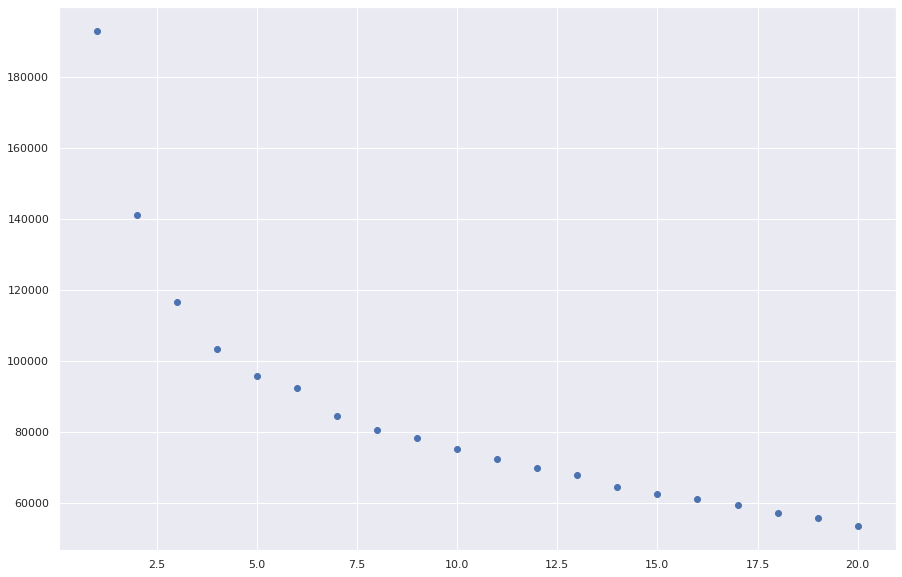

In [20]:
K = range(1,21)
models = [KMeans(n_clusters=k, random_state=42).fit(prep_seasons.T) for k in K]
dist = [model.inertia_ for model in models]
plt.figure(figsize=(15, 10))
plt.plot(K, dist, 'o')

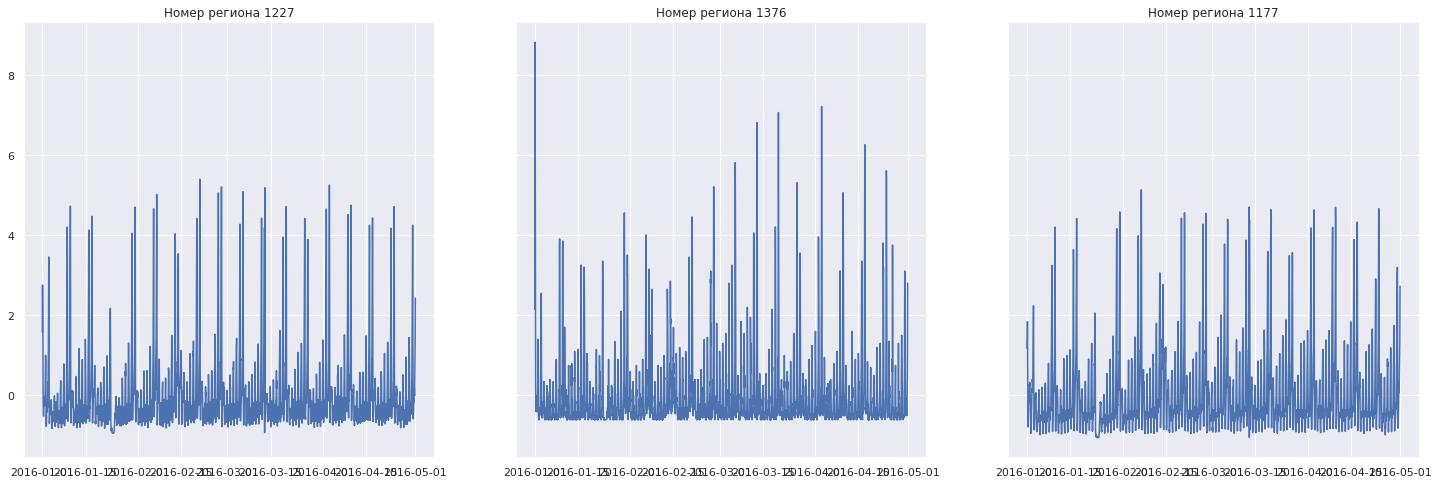

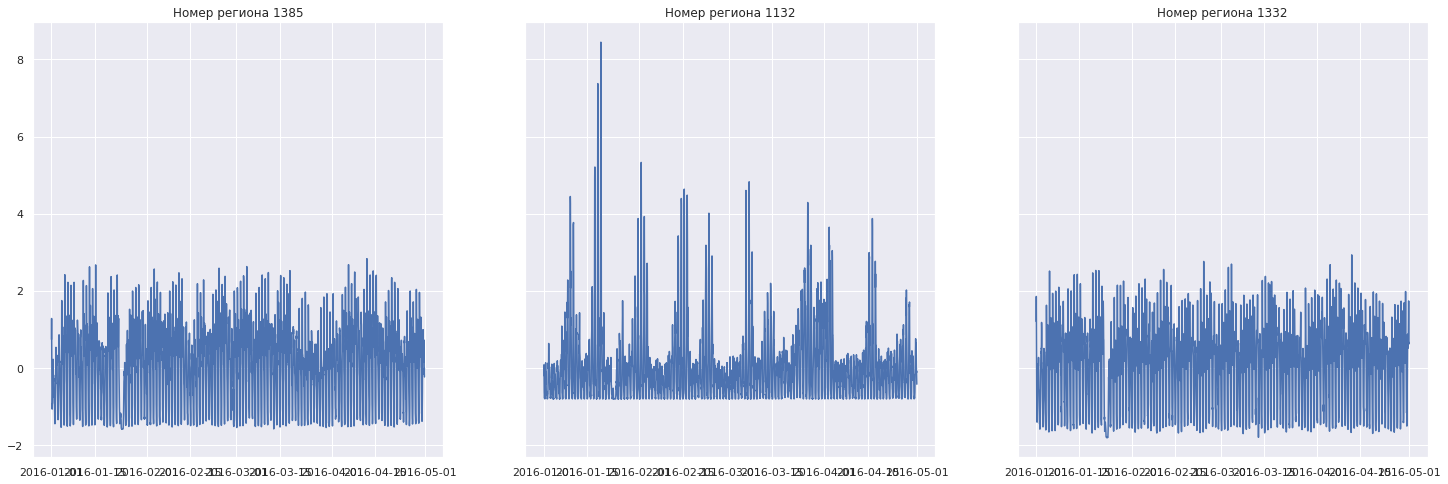

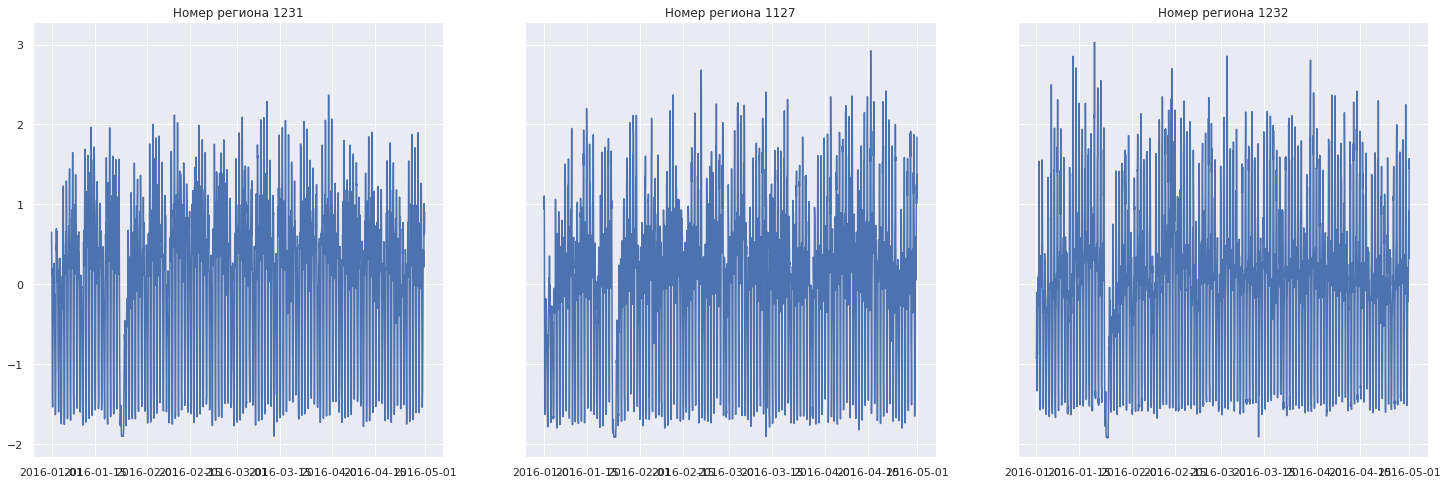

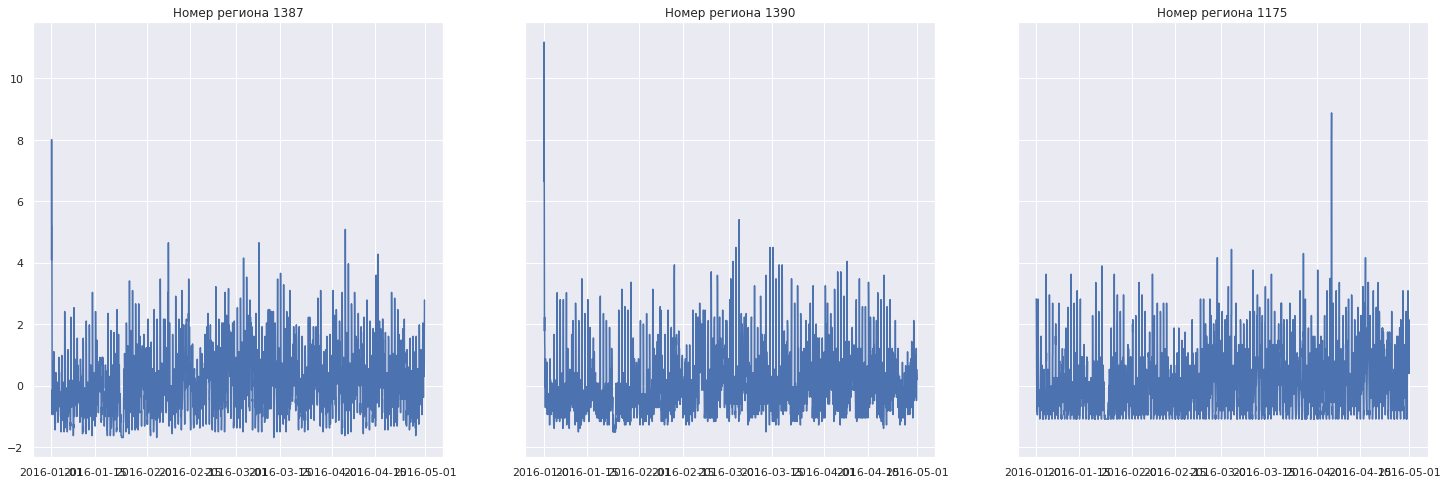

In [21]:
num_clusters = 4
cluster = KMeans(n_clusters=num_clusters, random_state=42).fit(prep_seasons.T)
pred = (cluster.predict(prep_seasons.T))
d = prep_seasons.columns.values
for i in set(pred):
    regions = []
    figure, axes = subplots(1,3,figsize=(25,8),sharey=True)
    for x in range(3):
        graf = d[(pred==i)][np.random.randint(len(d[(pred==i)]))]
        axes[x].plot(prep_seasons[graf])
        axes[x].set_title(f'Номер региона {graf}')

## Подбираем параметры

In [22]:
classter_region = {x: int(y) for x, y in zip(prep_seasons.columns, pred)}

In [23]:
# classter_region

In [24]:
time_serieses = pd.DataFrame({f'claster {x}': cluster.cluster_centers_[x, :] for x in range(num_clusters)}, index=prep_seasons.index)

In [25]:
best_class_opt = {}
coef = 0.75
for claster in range(num_clusters):
    time_series = pd.DataFrame(time_serieses[f'claster {claster}'])
    mse_list = []
    for number in range (1, 200):
        ols_data = time_series.copy()
        for i in range(1, number+1):        
            ols_data['s_'+str(i)] = np.sin(np.arange(1, time_series.shape[0]+1)*2*np.pi*i/168)
            ols_data['c_'+str(i)] = np.cos(np.arange(1, time_series.shape[0]+1)*2*np.pi*i/168)
        y = ols_data[f'claster {claster}']
        X = ols_data.loc[:, 's_1':]
        try:
            model = LinearRegression()
            res = model.fit(X.iloc[:int(len(X)*coef)], y.iloc[:int(len(X)*coef)])
            mse_list.append(mean_squared_error(y.iloc[int(len(X)*coef):], res.predict(X.iloc[int(len(X)*coef):])))
        except LinAlgError:
            print('wrong parameters:', number)
            continue
        except ValueError:
            print('wrong :', number)
            continue
    K_opt = np.argmin(mse_list)
    best_class_opt.update({f'claster {claster}': K_opt})
    print( 'Минимальное квадратичное отклонение достигнуто при K =', K_opt)

wrong parameters: 107
wrong parameters: 130
wrong parameters: 149
wrong parameters: 160
Минимальное квадратичное отклонение достигнуто при K = 78
wrong parameters: 107
wrong parameters: 130
wrong parameters: 149
wrong parameters: 160
Минимальное квадратичное отклонение достигнуто при K = 80
wrong parameters: 107
wrong parameters: 130
wrong parameters: 149
wrong parameters: 160
Минимальное квадратичное отклонение достигнуто при K = 81
wrong parameters: 107
wrong parameters: 130
wrong parameters: 149
wrong parameters: 160
Минимальное квадратичное отклонение достигнуто при K = 78


In [26]:
best_class_opt

{'claster 0': 78, 'claster 1': 80, 'claster 2': 81, 'claster 3': 78}

Критерий Дики-Фуллера для claster 0: p=0.000000


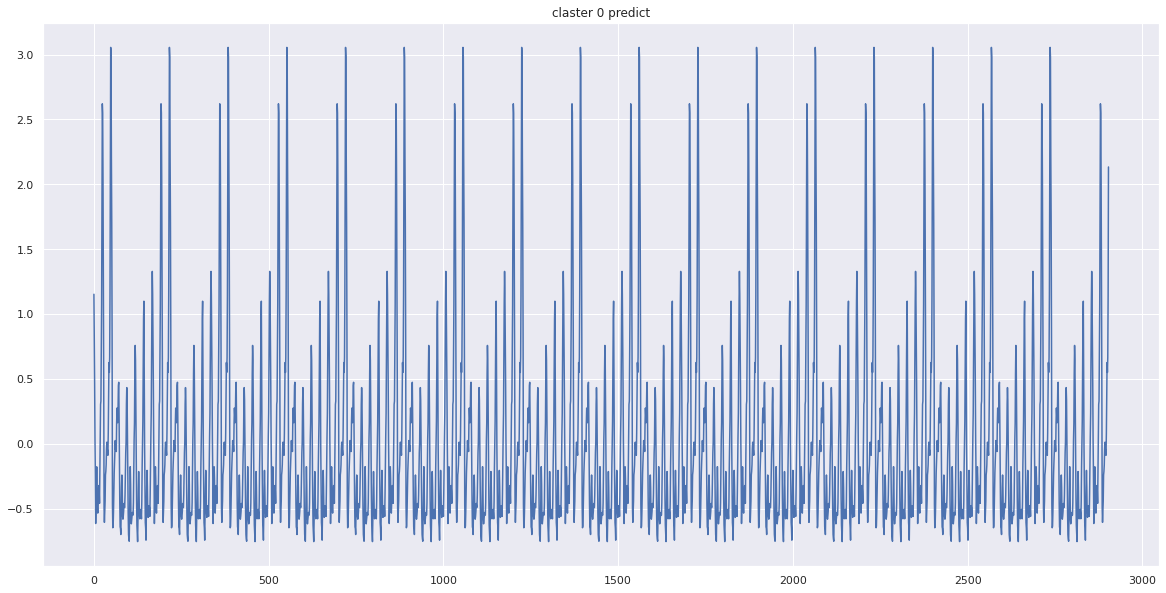

<Figure size 1440x720 with 0 Axes>

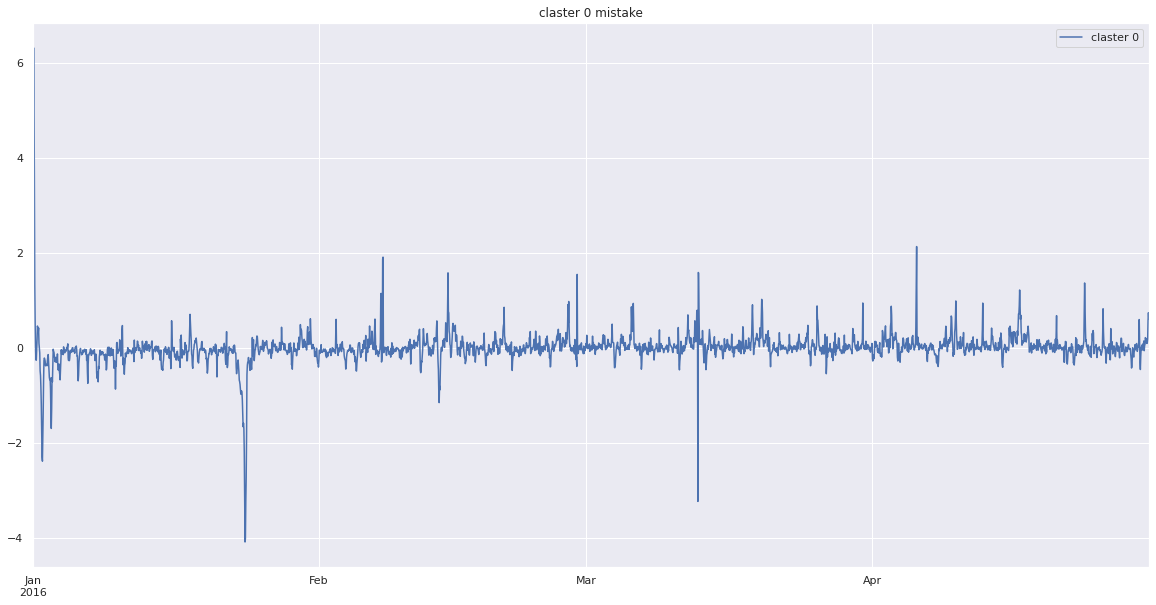

<Figure size 1800x1800 with 0 Axes>

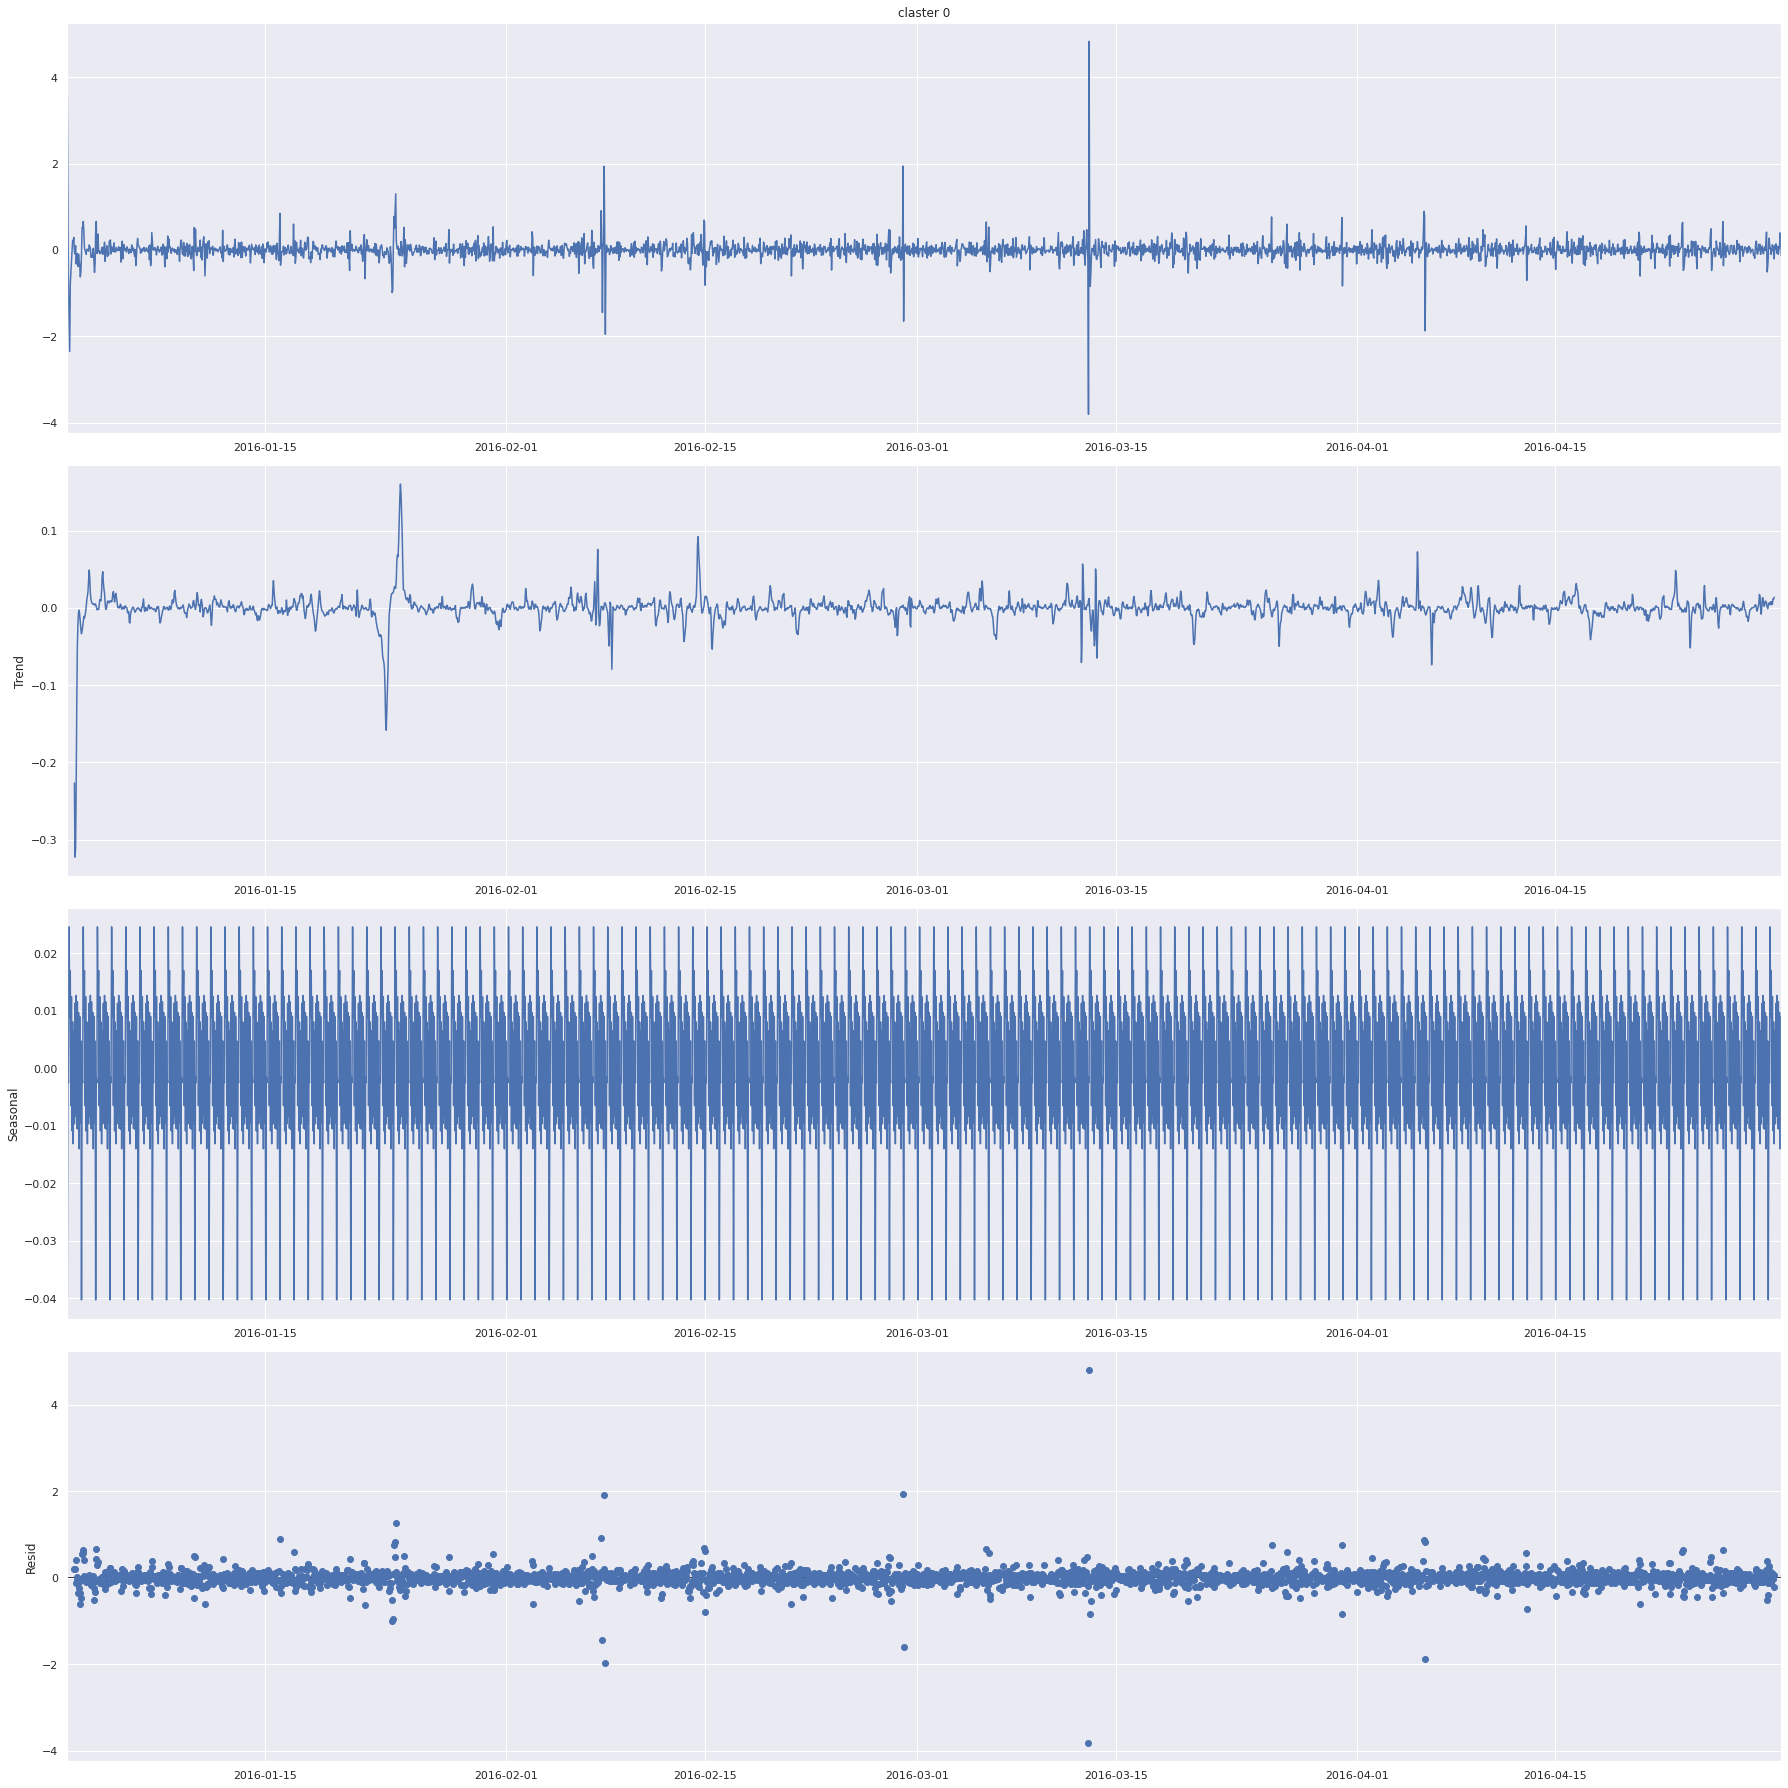

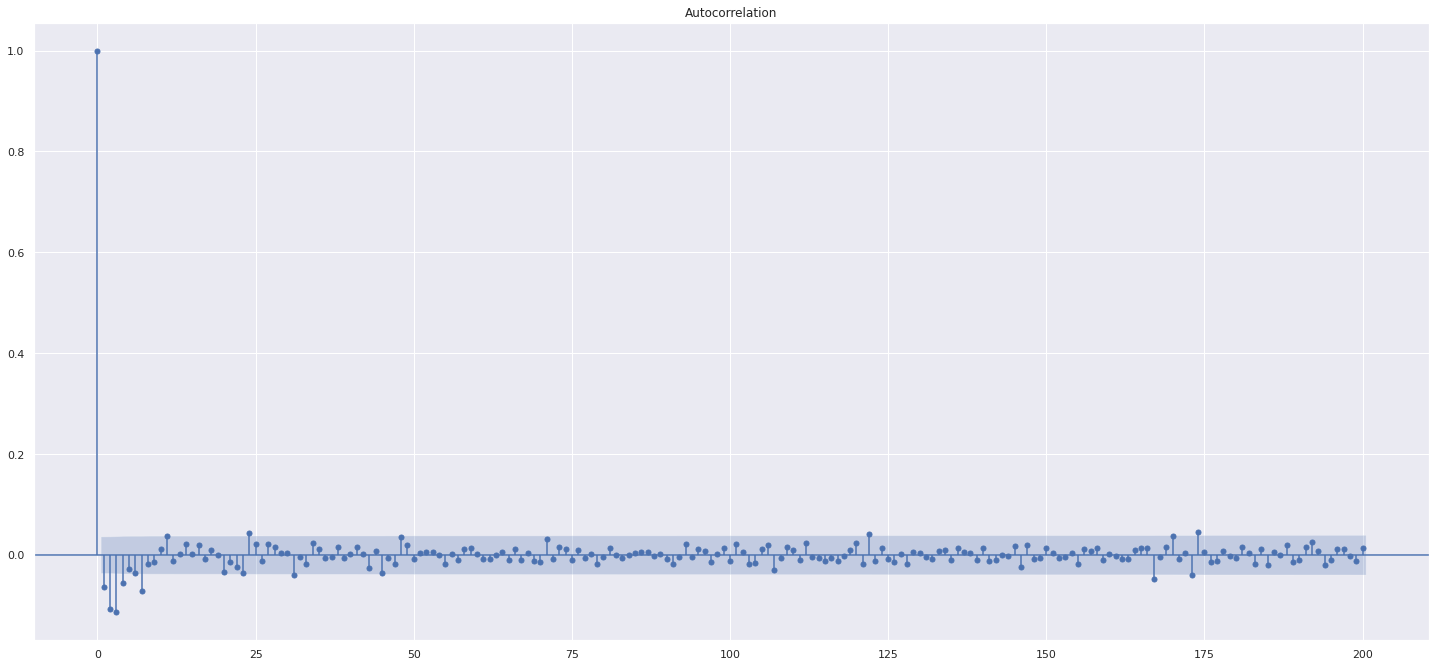

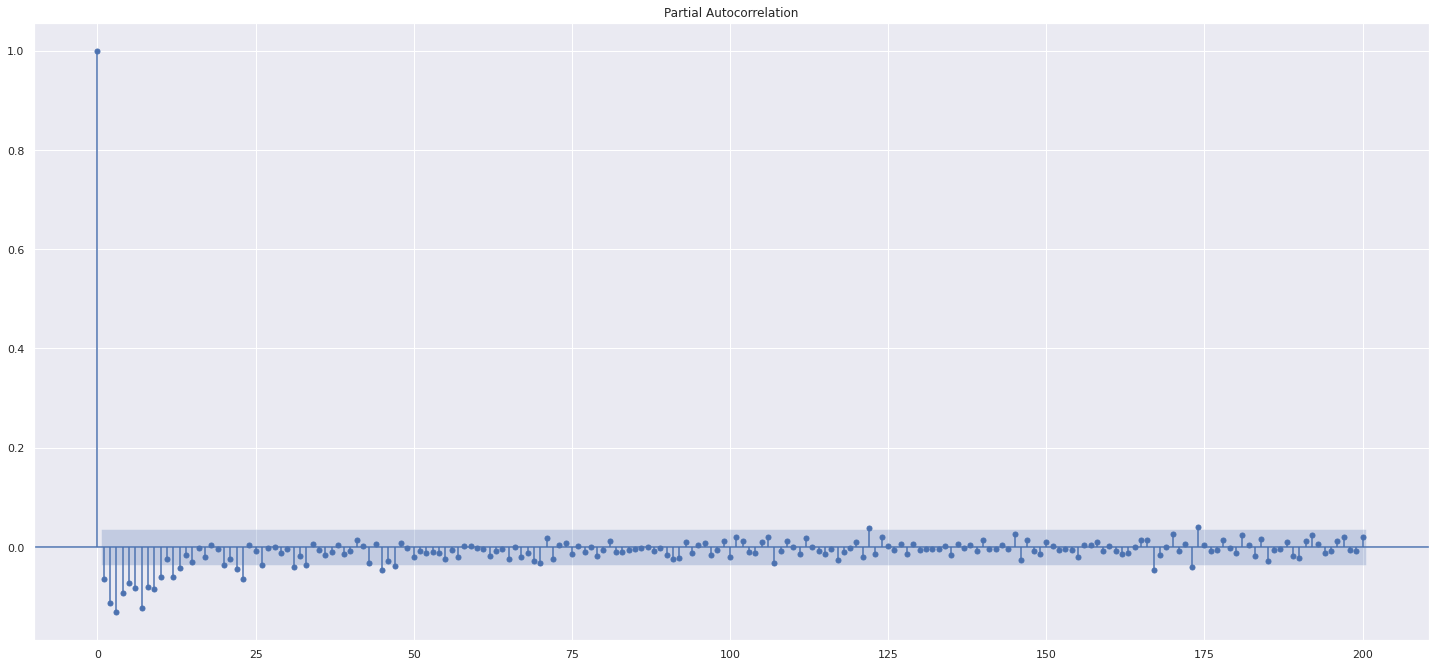

Критерий Дики-Фуллера для claster 1: p=0.000000


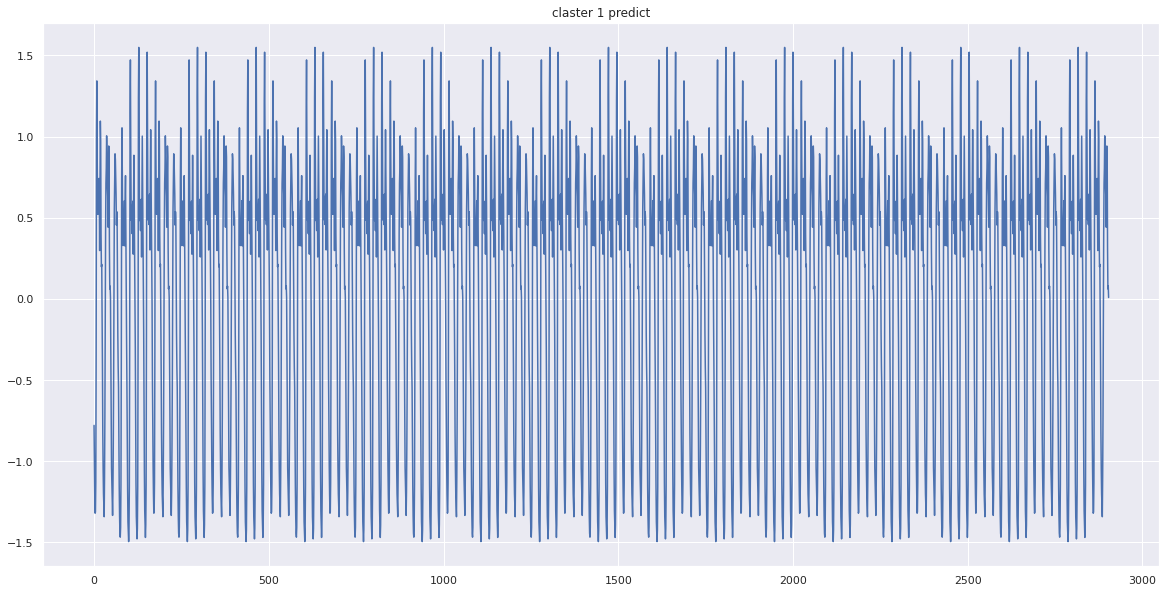

<Figure size 1440x720 with 0 Axes>

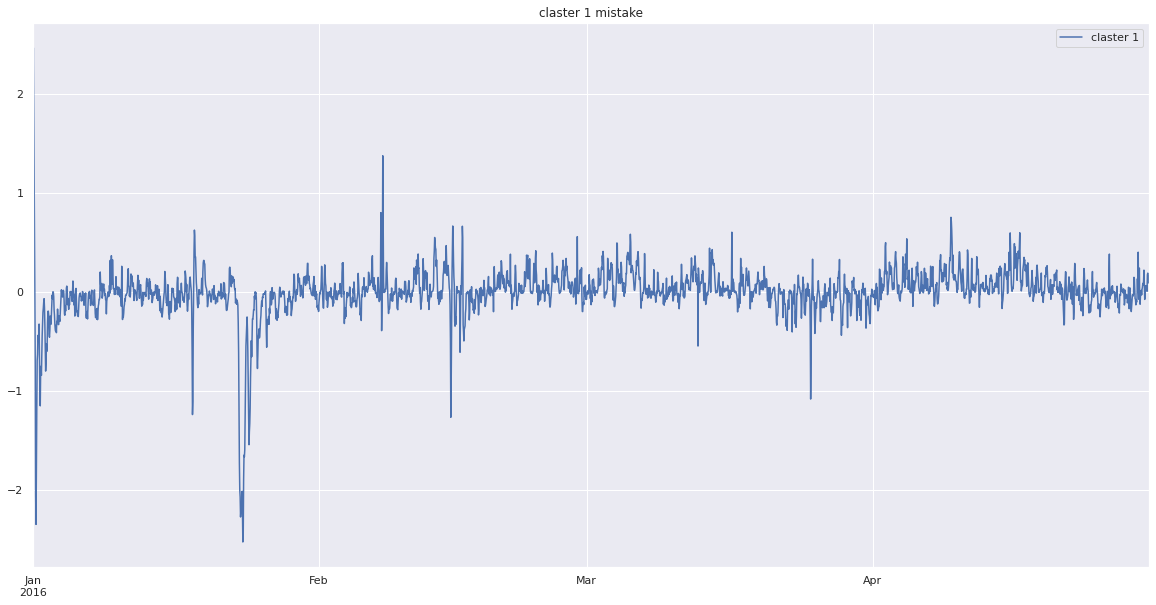

<Figure size 1800x1800 with 0 Axes>

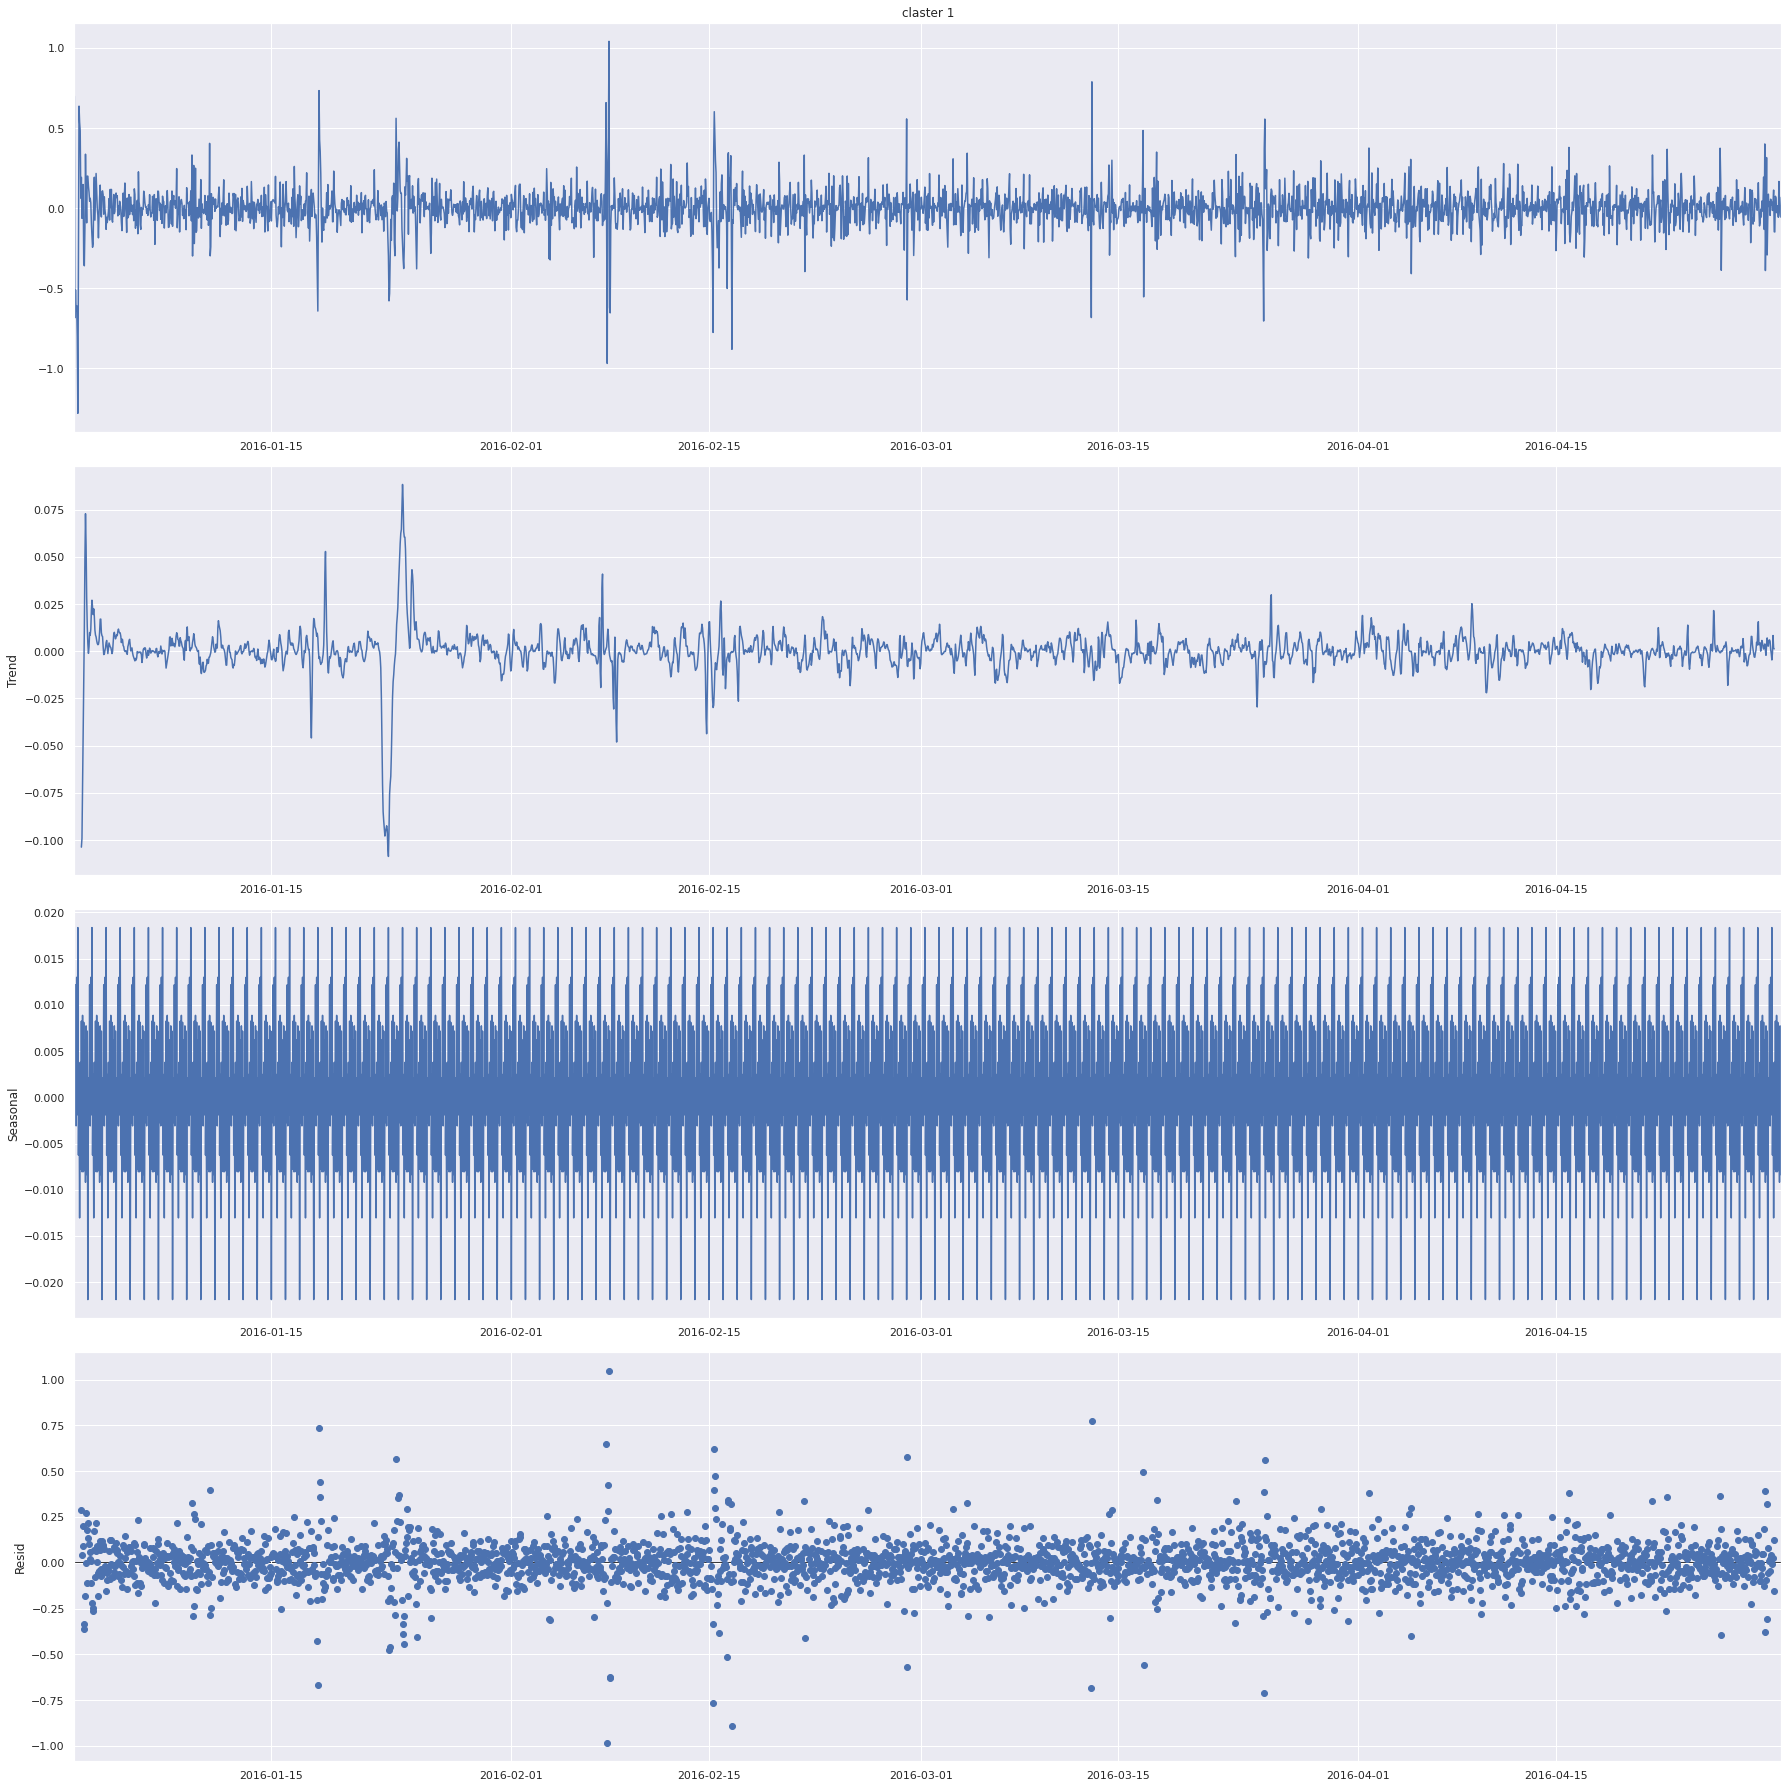

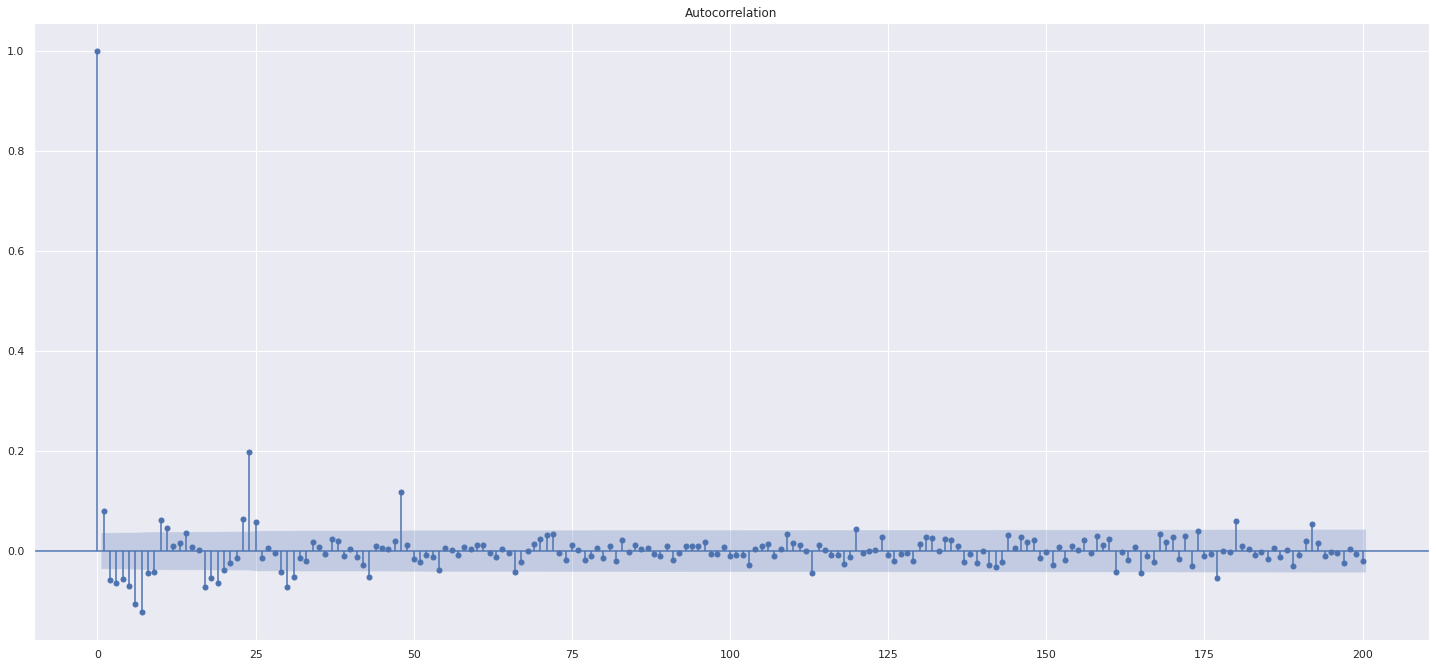

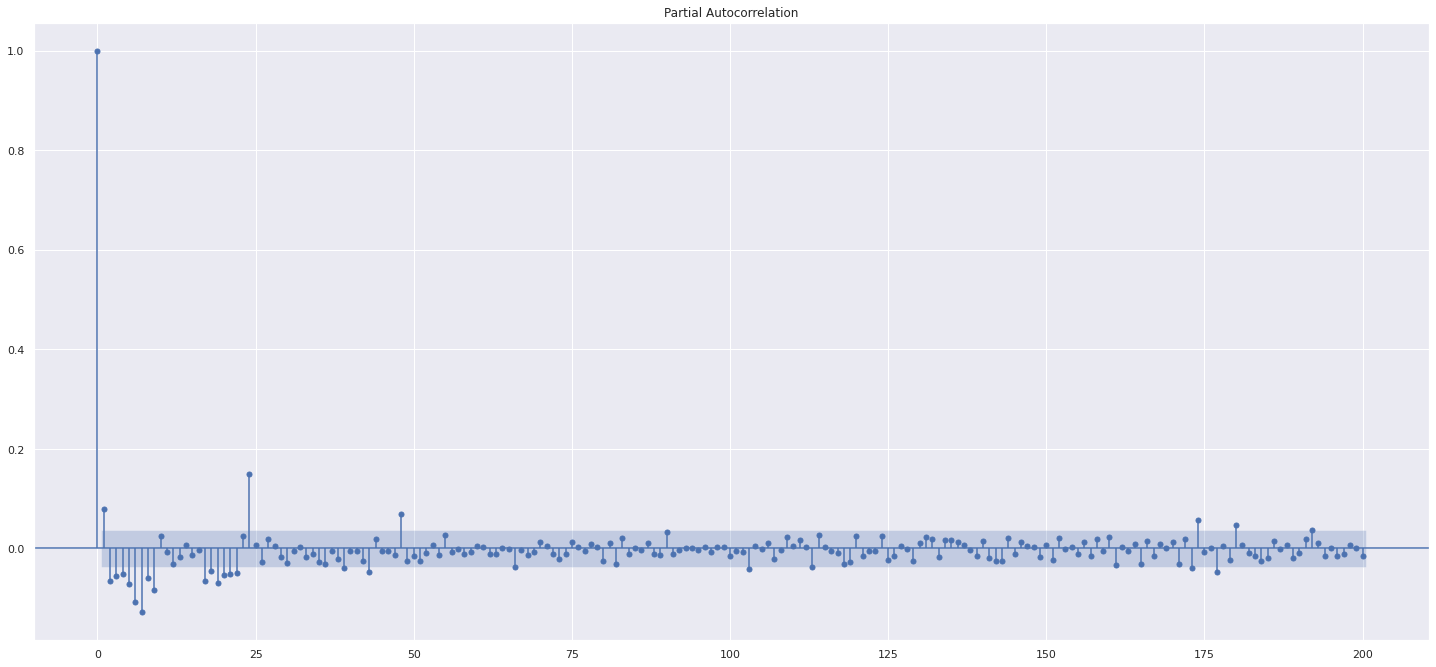

Критерий Дики-Фуллера для claster 2: p=0.000000


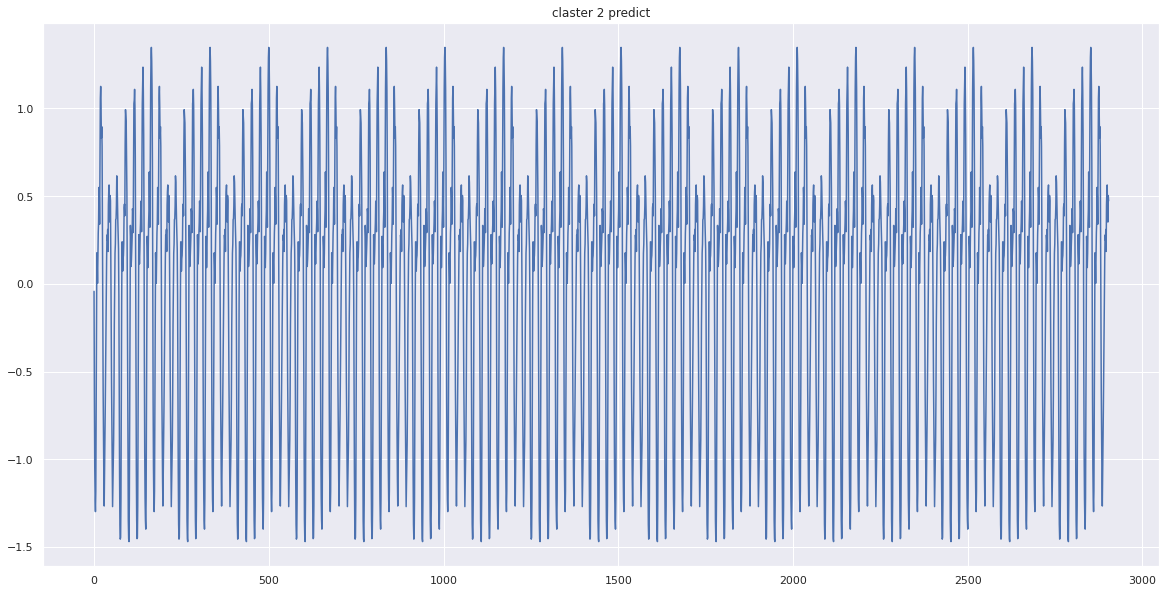

<Figure size 1440x720 with 0 Axes>

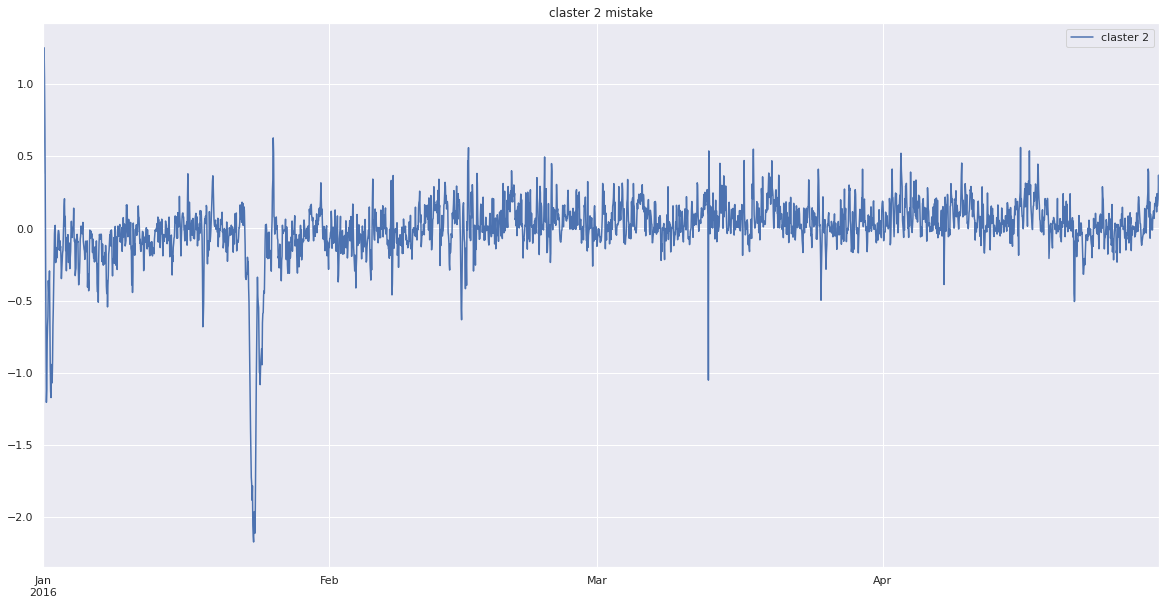

<Figure size 1800x1800 with 0 Axes>

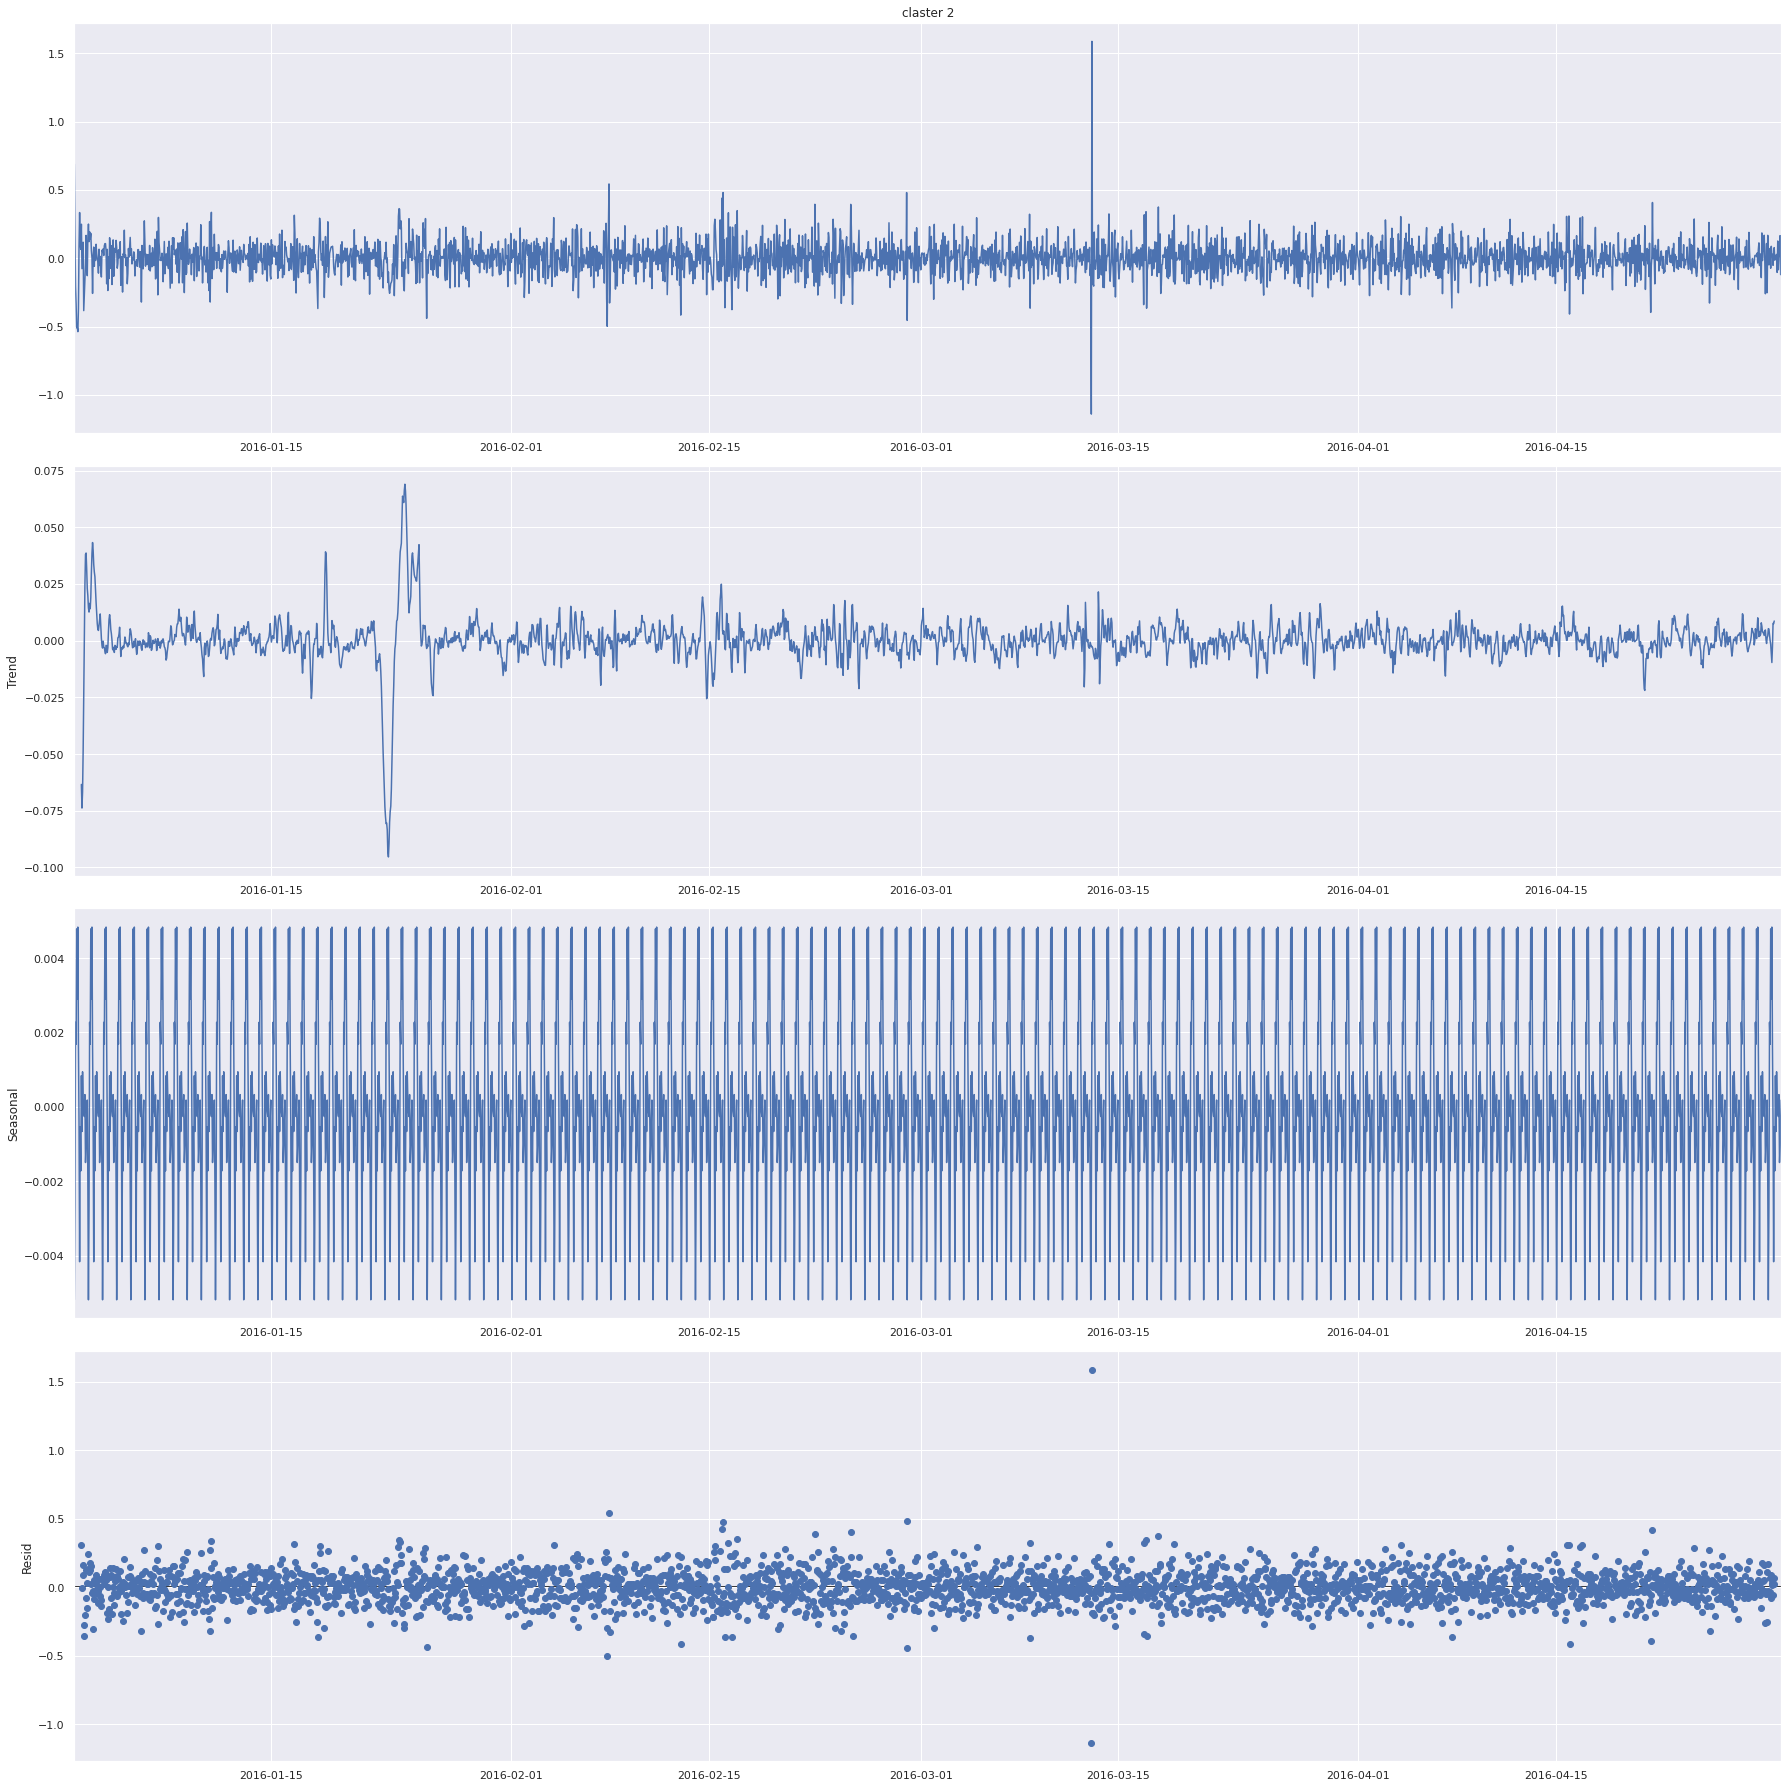

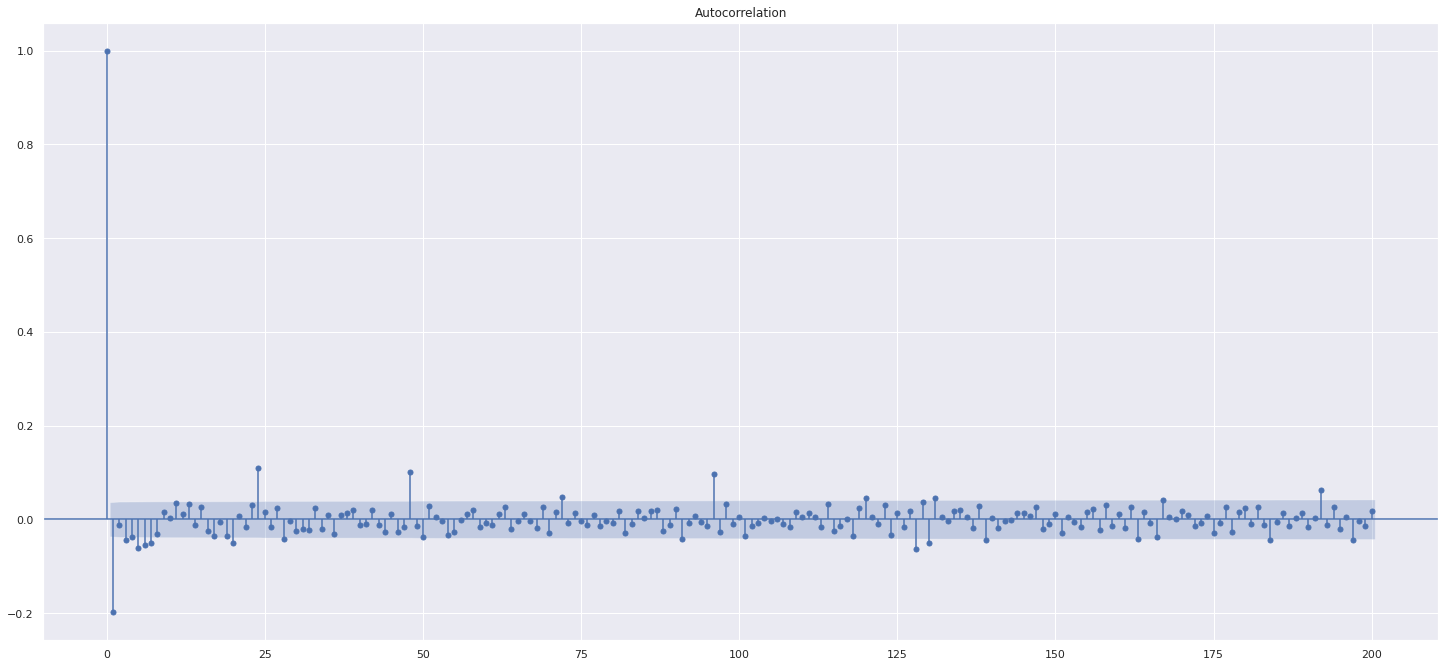

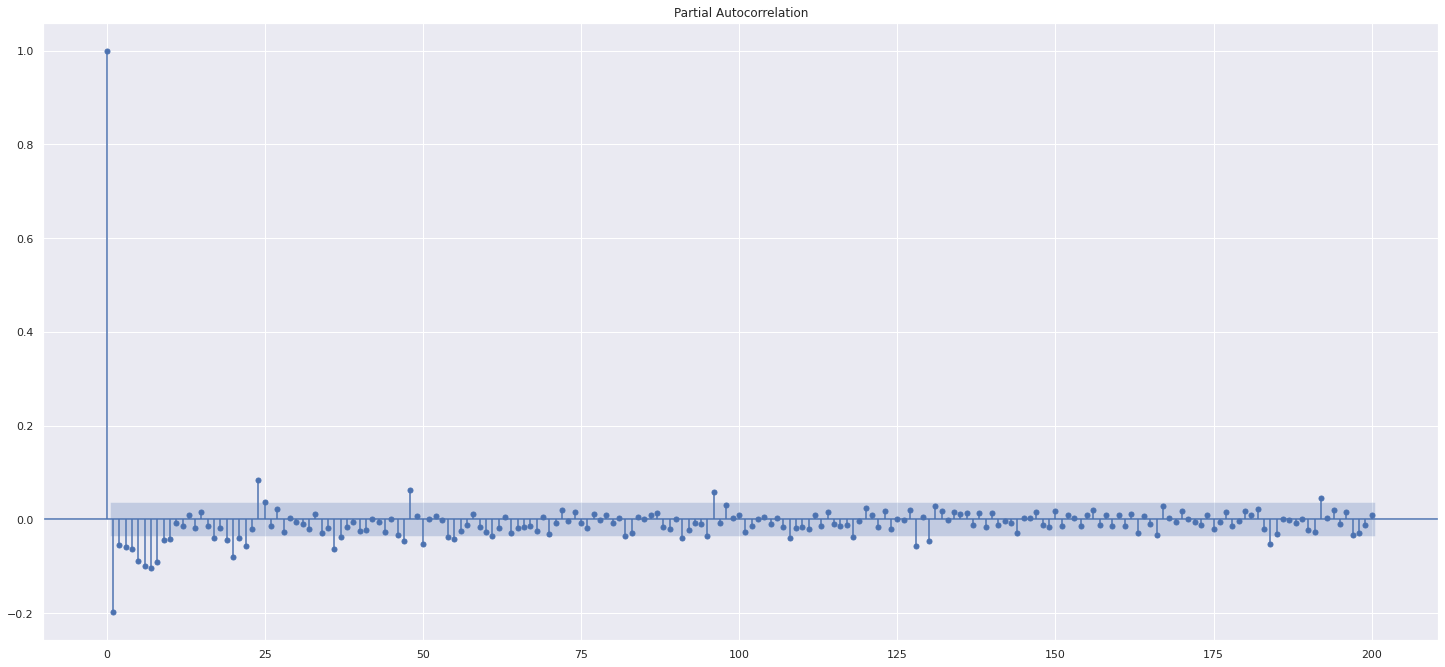

Критерий Дики-Фуллера для claster 3: p=0.000000


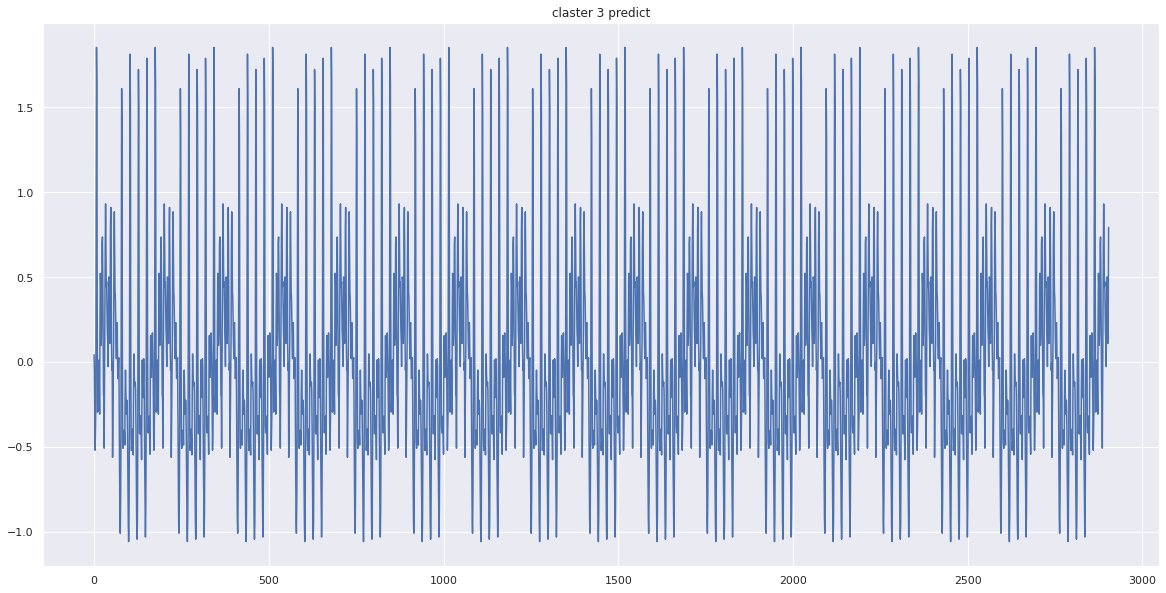

<Figure size 1440x720 with 0 Axes>

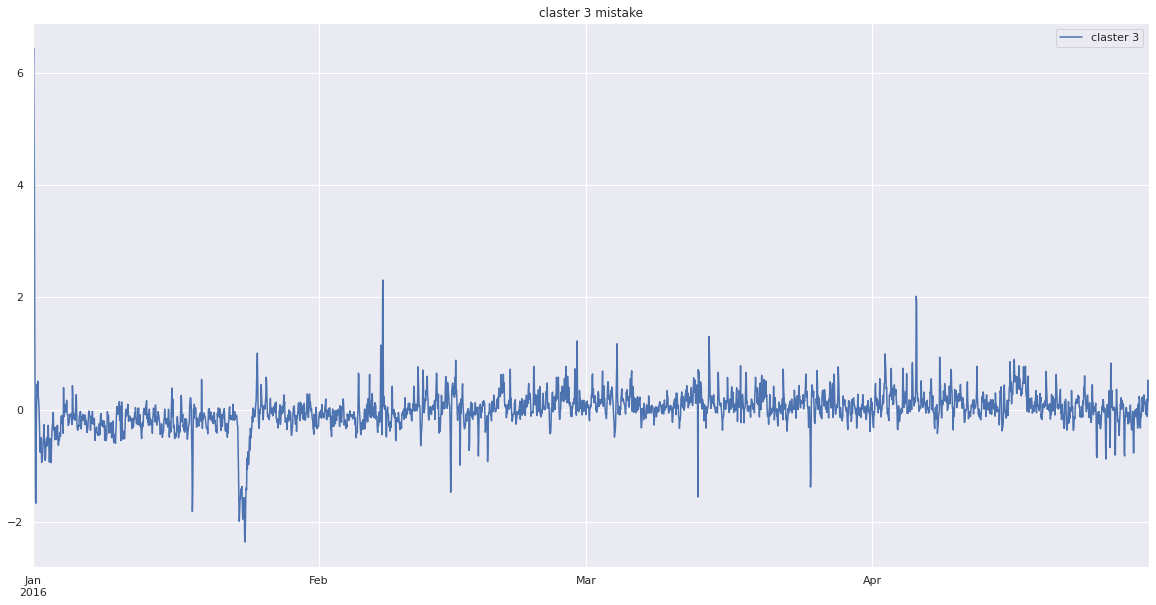

<Figure size 1800x1800 with 0 Axes>

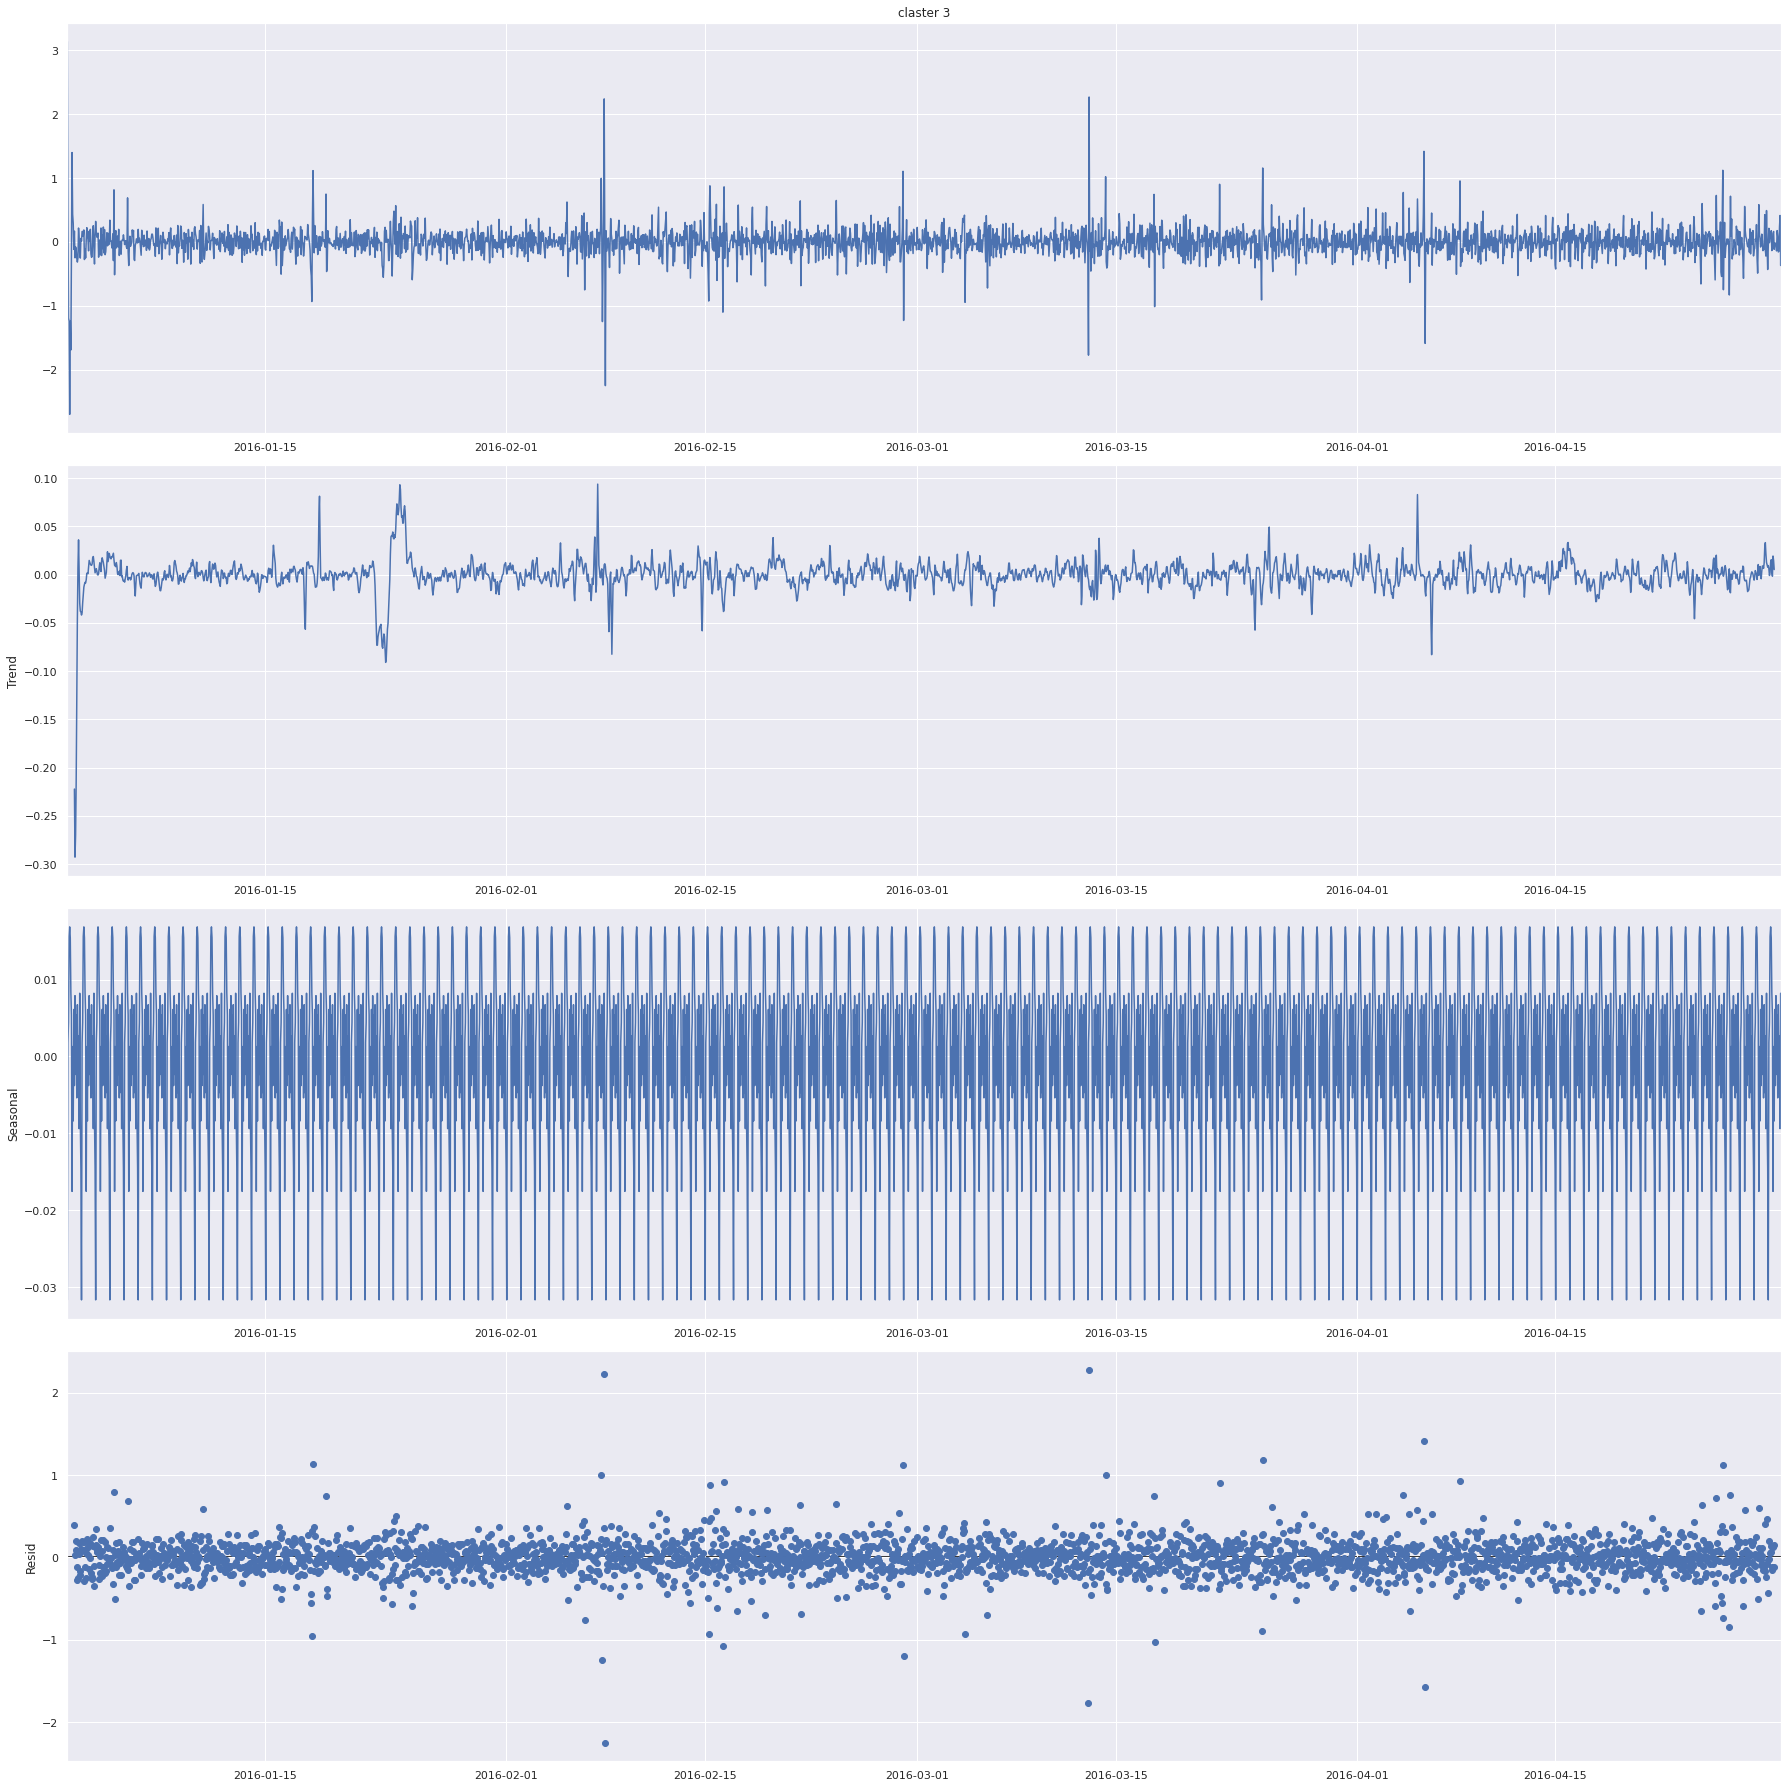

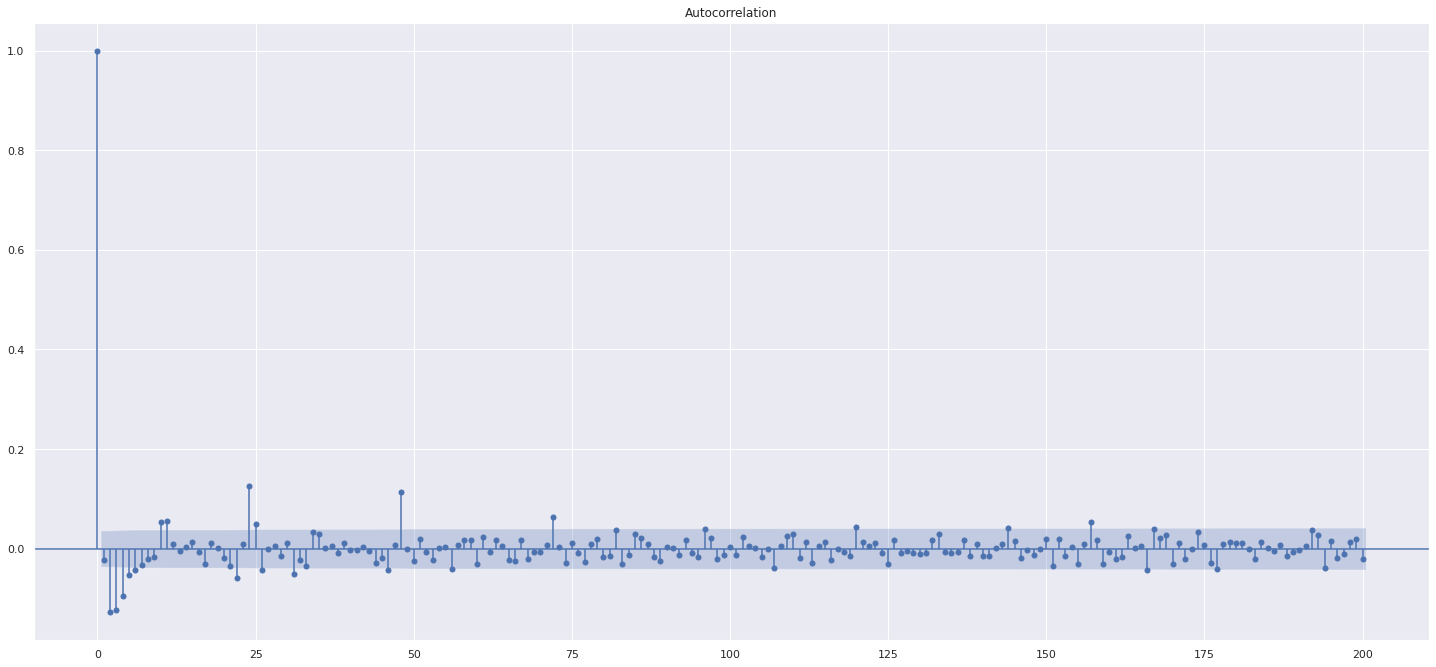

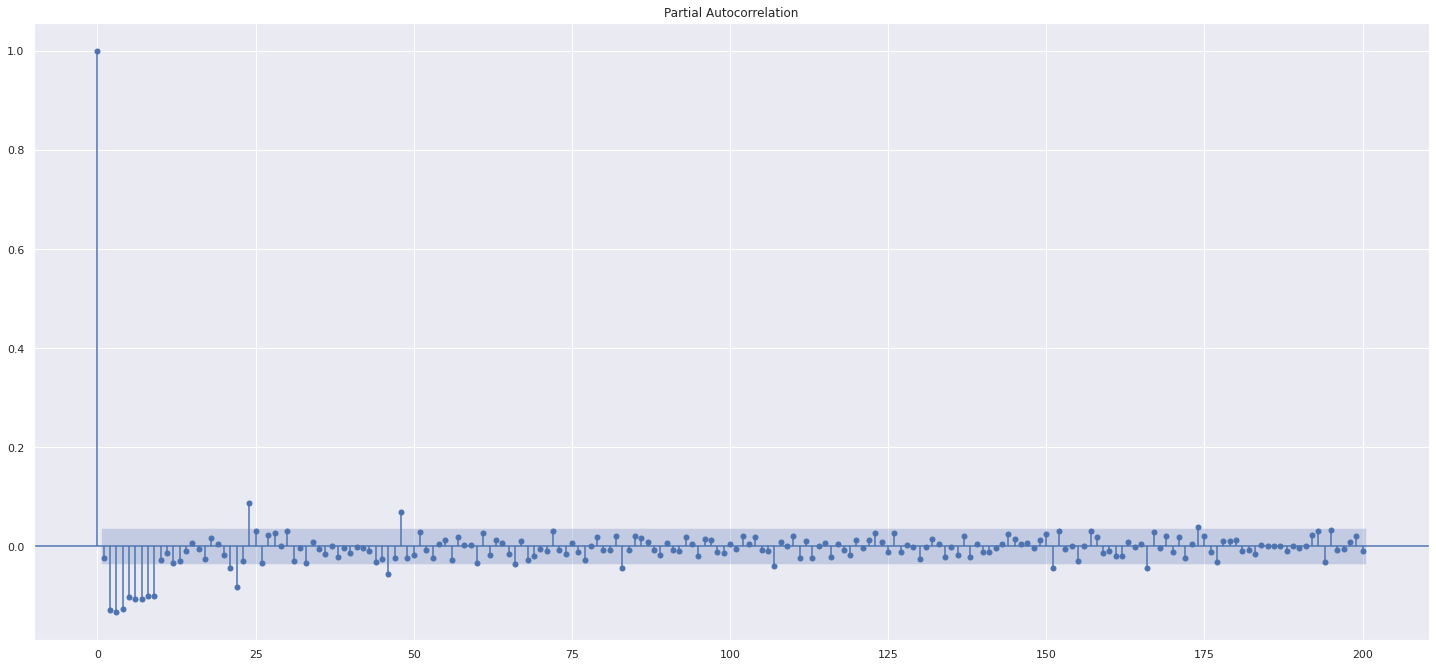

In [27]:
for x in best_class_opt.keys():
    time_series = pd.DataFrame(time_serieses[x])
    for i in range(1, best_class_opt[x] + 1):        
        time_series['s_'+str(i)] = np.sin(np.arange(1, time_series.shape[0]+1)*2*np.pi*i/168)
        time_series['c_'+str(i)] = np.cos(np.arange(1, time_series.shape[0]+1)*2*np.pi*i/168)
    y = time_series[x]
    X = time_series.loc[:, 's_1':]
    model = LinearRegression()
    res = model.fit(X, y)
    y_pred = res.predict(X)
    plt.figure(figsize=(20, 10))
    plt.plot(y_pred)
    plt.title(f'{x} predict')
    y_pred = pd.DataFrame({x: y_pred},time_series.index)
    plt.figure(figsize(20,10))
    time_vec = pd.DataFrame(time_series[x] - y_pred[x])
    time_vec.plot()
    plt.title(f'{x} mistake')
    plt.figure(figsize(25,25))
    diff_time_vec = diff_model(time_vec,[1], x).dropna()
    sm.tsa.seasonal_decompose(diff_time_vec[x]).plot()   
    print(f"Критерий Дики-Фуллера для {x}: p=%f" % sm.tsa.stattools.adfuller(time_vec)[1])
    plt.figure(figsize(25,25))
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf((diff_time_vec.dropna()).values.squeeze(), lags=200, ax=ax)
    pylab.show()
    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf((diff_time_vec.dropna()).values.squeeze(), lags=200, ax=ax)
    pylab.show()

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults, SARIMAXResultsWrapper

In [29]:
aut_cor_par = {'claster 0': {'ps': 4,'qs': 1,'Ps': 3,'Qs': 0}, 'claster 1': {'ps': 2,'qs': 1,'Ps': 5,'Qs': 0}, 'claster 2': {'ps': 4,'qs': 1,'Ps': 3,'Qs': 0}, 'claster 3': {'ps': 4,'qs': 1,'Ps': 3,'Qs': 0}}

In [30]:
# model = SARIMAXResultsWrapper(SARIMAXResults.load('claster_3'))

In [31]:
# model.specification

In [32]:
d=1
D=0
models_params = dict()
models = dict()
aut_cor_par = {'claster 0': {
                'ps': 8,
                'qs': 7,
                'Ps': 2,
                'Qs': 2
              },
              'claster 1': {
                'ps': 10,
                'qs': 8,
                'Ps': 1,
                'Qs': 1
              },
              'claster 2': {
                'ps': 7,
                'qs': 6,
                'Ps': 2,
                'Qs': 2
              },
              'claster 3': {
                'ps': 9,
                'qs': 6,
                'Ps': 2,
                'Qs': 2
              }}
for clas in best_class_opt.keys():
    ps = range(1, int(aut_cor_par[clas]['ps'])+1)
    qs = range(1, int(aut_cor_par[clas]['qs'])+1)
    Ps = range(0, int(aut_cor_par[clas]['Ps'])+1) 
    Qs = range(0, int(aut_cor_par[clas]['Qs'])+1)

    parameters = product(ps, qs, Ps, Qs)
    parameters_list = list(parameters)

    time_series = pd.DataFrame(time_serieses[clas])
    ols_data = time_series.copy()
    for i in range(1, best_class_opt[clas]+1):        
        ols_data['s_'+str(i)] = np.sin(np.arange(1, time_series.shape[0]+1)*2*np.pi*i/168)
        ols_data['c_'+str(i)] = np.cos(np.arange(1, time_series.shape[0]+1)*2*np.pi*i/168)
    X = ols_data.loc[:, 's_1':]
    
    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore')

    for param in tqdm(parameters_list):
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(time_series[clas], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 24), exog=X,initialization='approximate_diffuse').fit(disp=-1)
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            print('wrong parameters:', param)
            continue
        except LinAlgError :
            print('wrong:', param)
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    models.update({clas: best_model})
    models_params.update({clas: best_param})

    warnings.filterwarnings('default')

  1%|▏         | 7/504 [1:09:27<82:11:42, 595.38s/it]


KeyboardInterrupt: 

In [52]:
models_params

{'claster 0': (1, 1, 0, 0),
 'claster 1': (1, 1, 0, 0),
 'claster 2': (1, 1, 0, 0),
 'claster 3': (1, 1, 0, 0)}

In [28]:
models_params = {'claster 0': [7, 1, 6, 0], 'claster 1': [2, 1, 6, 0], 'claster 2': [6, 1, 5, 0], 'claster 3': [5, 1, 5, 0]}

## Настраиваю модель и считаю ошибку на май

In [29]:
mistake = 0
split_time = TimeSplit(test.index, 0, 6, 1)
iter_time = iter(split_time)
for region in tqdm(classter_region.keys()):
    clas = classter_region[region]
    param = models_params[f'claster {clas}']
    optim = best_class_opt[f'claster {clas}']
    X_train = create_add_regreassors(prep_seasons, region, optim)
    X_test = create_add_regreassors(test, region, optim)
    model=sm.tsa.statespace.SARIMAX(prep_seasons[region], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 24), exog=X_train,initialization='approximate_diffuse').fit(disp=-1)
    for i in iter_time:
        new_observation = test[region].loc[i[0]]
        exog_train = X_test.loc[i[0]]
        exog_test = X_test.loc[i[1]]
        if len(i[0]) == 0:
            update_res = model
        else:
            update_res = model.append(new_observation, exog=exog_train)
        forecast = update_res.forecast(len(i[1]), exog=exog_test)
        mistake += metric(forecast, test.loc[i[1]][region])

  0%|          | 0/102 [07:03<?, ?it/s]


KeyboardInterrupt: 

In [263]:
mistake/len(classter_region.keys())/739/6*mean(scaler.scale_)*102

/home/vladislav/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


47.60509148277231

In [206]:
inverse_data = {test.columns[i]: [scaler.mean_[i], scaler.scale_[i]] for i in range(len(test.columns))}
sample_predict = pd.DataFrame(data=np.zeros((715*102*6, 2)), columns=['id', 'y'])

/home/vladislav/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Делаю предикт на июне

In [397]:
mistake = 0
new_sample_predict = pd.DataFrame(columns=['id', 'y'])
# predict = pd.concat((test.iloc[-6:], predict))
# test = test.iloc[:-6]
for time_zone, region in tqdm(enumerate(classter_region.keys())):
    split_time = TimeSplit(predict.index, 0, 6, 1)
    iter_time = iter(split_time)
    clas = classter_region[region]
    param = models_params[f'claster {clas}']
    optim = best_class_opt[f'claster {clas}']
    X_train = create_add_regreassors(pd.concat((prep_seasons, test)), region, optim)
    X_test = create_add_regreassors(predict, region, optim)
    model=sm.tsa.statespace.SARIMAX(pd.concat((prep_seasons[region], test[region])), order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 24),
                                    exog=X_train,initialization='approximate_diffuse').fit(disp=-1)
    for z, i in enumerate(iter_time):
        new_observation = predict[region].loc[i[0]]
        exog_train = X_test.loc[i[0]]
        exog_test = X_test.loc[i[1]]
        if len(i[0]) == 0:
            update_res = model
        else:
            update_res = model.append(new_observation, exog=exog_train)
        forecast = update_res.forecast(len(i[1]), exog=exog_test)
        forecast = forecast * inverse_data[region][1] + inverse_data[region][0]
        forecast = forecast[(forecast.index >= pd.to_datetime("31-5-16 23")) & (forecast.index <= pd.to_datetime("30-6-16 17"))]
        forecast.index = [f"{region}_{str(x).split(' ')[0]}_{x.hour}_{str(z+1)}" 
                                                 for z,x in enumerate(forecast.index)]
        new_sample_predict = pd.concat((new_sample_predict, pd.DataFrame({'id': forecast.index,'y': forecast.values})))
#         sample_predict.iloc[(time_zone * 715 + z)*6 : (time_zone * 715 + z+1)*6, 1] = forecast.values
#         sample_predict.iloc[(time_zone * 715 + z)*6 : (time_zone * 715 + z+1)*6, 0] = [f"{region}_{str(x).replace('-', '_').split(' ')[0]}_{x.hour}_{str(z+1)}" 
#                                                  for z,x in enumerate(forecast.index)]
        

/home/vladislav/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
0it [00:00, ?it/s]/home/vladislav/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/vladislav/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
4it [09:27, 141.80s/it]/home/vladislav/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting M

In [ ]:
new_sample_predict = new_sample_predict.sort_values('id')
new_sample_predict['id'] = [f'{x}_{z%6 + 1}' for z, x in enumerate(new_sample_predict['id'])]
new_sample_predict.to_csv('new_predict_1.csv', index=False)

## Ссылка на сабмишин  https://www.kaggle.com/submissions/19738775/19738775.raw

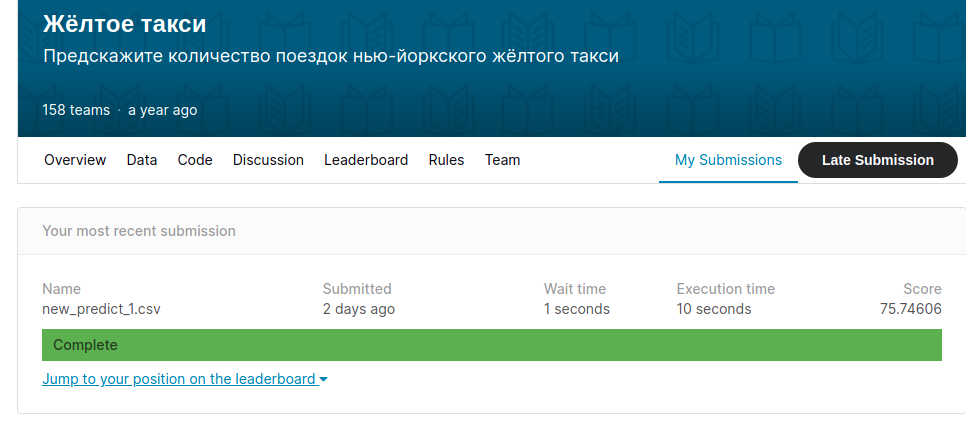

In [1]:
model

NameError: name 'model' is not defined

In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

In [ ]:
model